## scRNA-Seq AGM R. Thambyrajah and A. Bigas data analysis 
### Notebook created by Yolanda Guillén
#### October 2021 - Barcelona

In [1]:
# Import packages, an rename them
#scanpy
import scanpy as sc
#pandas for dataframe management
import pandas as pd
#numpy for matrix management
import numpy as np
# seaborn for statistical data visualization
import seaborn as sns
# mygene for gene symbol conversion
import mygene
#import desc as DESC
import hvplot.pandas
# import leidenalg for clustering
import leidenalg as ig
from matplotlib.colors import LinearSegmentedColormap
import cellbrowser

In [57]:
# Settings for scanpy
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '../write/scRNA_AGM.h5ad'  # the file that will store the analysis results
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.2.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [58]:
# Set resolution/size, styling and format of figures. # (dpi higher to achieve publication quality)
sc.settings.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, 
 vector_friendly=True, fontsize=14, format='pdf', 
 transparent=False, ipython_format='png2x')
#sc.settings.set_figure_params(dpi=80)

#### Set path for input count matrix here

In [59]:
## For all cells

In [60]:
# In case of using htseq counts for SmartSeq2, we need to normalize the counts previously in R. If not, we can normalize with
# proportions here in scanpy. But for more sophisticated methods, do it in R. Remember to transpose! (Shaonang)
# In htseq counts, we need to remove last rows. (T or transpose())

#adata = sc.read_text('/Volumes/cancer/Rosh_scRNA/htseq/htseq_counts_genes.txt').T

# Home laptop
#adata = sc.read_text('/Users/yolanda_guillen/Desktop/IMIM/scRNA_cam/all_scRNA_2021/cellbrowser_output/htseq_counts_genes.txt').T
# Lab Mac
adata = sc.read_text('/Volumes/grcmc/YGUILLEN/scRNA_Roshana_MCR/all_scRNA_2021/cellbrowser_output/htseq_counts_genes.txt').T

In [61]:
adata

AnnData object with n_obs × n_vars = 860 × 46170 

#### Set path for gene dataset and cycle data here

In [62]:
# For all cells

In [63]:
# Read the gene table file for gene annotations. Make sure the genes are unique
#genes = pd.read_csv('/Volumes/grcmc/YGUILLEN/scRNA_cam/scanpy_run/genes.tsv',sep='\t',
#                                header=None)
#genes = pd.read_csv('/Volumes/cancer/db_files/STAR/gene_names_mouse.txt',sep='\t',
#                                header=None)
# Home laptop
#genes = pd.read_csv('/Users/yolanda_guillen/Desktop/IMIM/scRNA_cam/all_scRNA_2021/cellbrowser_output/gene_names_mouse.txt',sep='\t',
#                                header=None)
# Lab mac
genes = pd.read_csv('/Volumes/grcmc/YGUILLEN/scRNA_Roshana_MCR/all_scRNA_2021/cellbrowser_output/gene_names_mouse.txt',sep='\t',
                                header=None)

In [66]:
# Read the cycle phase from cyclone (R)
cycle = pd.read_csv('/Users/yolanda_guillen/Desktop/IMIM/scRNA_cam/all_scRNA_2021/cellbrowser_output/cyclone_scRNAseq.txt',sep='\t',
                   header=None)
# Also the scores for each phase to regress out if necessary.

# Home laptop
#G1score=pd.read_csv('/Users/yolanda_guillen/Desktop/IMIM/scRNA_cam/all_scRNA_2021/cellbrowser_output/G1_score_cyclone.txt',sep='\t',header=None)
#G2Mscore=pd.read_csv('/Users/yolanda_guillen/Desktop/IMIM/scRNA_cam/all_scRNA_2021/cellbrowser_output/G2M_score_cyclone.txt',sep='\t',header=None)
#Sscore=pd.read_csv('/Users/yolanda_guillen/Desktop/IMIM/scRNA_cam/all_scRNA_2021/cellbrowser_output/S_score_cyclone.txt',sep='\t',header=None)

# Lab mac
G1score=pd.read_csv('/Volumes/grcmc/YGUILLEN/scRNA_Roshana_MCR/all_scRNA_2021/cellbrowser_output/G1_score_cyclone.txt',sep='\t',header=None)
G2Mscore=pd.read_csv('/Volumes/grcmc/YGUILLEN/scRNA_Roshana_MCR/all_scRNA_2021/cellbrowser_output/G2M_score_cyclone.txt',sep='\t',header=None)
Sscore=pd.read_csv('/Volumes/grcmc/YGUILLEN/scRNA_Roshana_MCR/all_scRNA_2021/cellbrowser_output/S_score_cyclone.txt',sep='\t',header=None)



In [67]:
print(adata.shape)
print(genes.shape)
print(cycle.shape)
print(G1score.shape)
print(G2Mscore.shape)
print(Sscore.shape)

(860, 46170)
(46170, 2)
(860, 2)
(860, 2)
(860, 2)
(860, 2)


In [68]:
adata.var['gene_ids'] = genes[0].values
adata.var['gene_symbols'] = genes[1].values
adata.var_names = adata.var['gene_symbols']
print(adata.var)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


                        gene_ids gene_symbols
gene_symbols                                 
Gnai3         ENSMUSG00000000001        Gnai3
Pbsn          ENSMUSG00000000003         Pbsn
Cdc45         ENSMUSG00000000028        Cdc45
H19           ENSMUSG00000000031          H19
Scml2         ENSMUSG00000000037        Scml2
...                          ...          ...
NaN                   ERCC-00164          NaN
NaN                   ERCC-00165          NaN
NaN                   ERCC-00168          NaN
NaN                   ERCC-00170          NaN
NaN                   ERCC-00171          NaN

[46170 rows x 2 columns]


#### Set path for cells metadata here

In [69]:
adata.var_names_make_unique

<bound method AnnData.var_names_make_unique of AnnData object with n_obs × n_vars = 860 × 46170 
    var: 'gene_ids', 'gene_symbols'>

In [70]:
# Read metadata without header (first, sort the order in bash of both files to be merged)
#cells = pd.read_csv('/Volumes/cancer/Rosh_scRNA/scanpy/FACS_data/metadata_facs.txt2',sep="\t",header=None)
# Home laptop
#cells = pd.read_csv('/Users/yolanda_guillen/Desktop/IMIM/scRNA_cam/all_scRNA_2021/cellbrowser_output/metadata_facs.txt2',sep="\t",header=None)

# Lab mac
cells = pd.read_csv('/Volumes/grcmc/YGUILLEN/scRNA_Roshana_MCR/all_scRNA_2021/cellbrowser_output/metadata_facs.txt2',sep="\t",header=None)

cells.shape

(860, 16)

In [71]:
adata.obs['Time'] = cells[1].values
adata.obs['Population'] = cells[2].values
adata.obs['Batch'] = cells[3].values
adata.obs['Batch_name'] = cells[4].values

In [72]:
# Asign metadata to adata using adata.obs and columns number
adata.obs['Time'] = cells[3].values
adata.obs['Population'] = cells[4].values
adata.obs['Batch'] = cells[5].values
adata.obs['Batch_name'] = cells[6].values
adata.obs['Plate_well'] = cells[1].values
adata.obs['DLL4'] = cells[7].values
adata.obs['NOTCH2'] = cells[8].values
adata.obs['CKIT'] = cells[9].values
adata.obs['GFI1'] = cells[10].values
adata.obs['CD41'] = cells[11].values
adata.obs['NOTCH1'] = cells[12].values
adata.obs['CD31'] = cells[13].values
adata.obs['JAG1'] = cells[14].values
adata.obs['CD45'] = cells[15].values

In [73]:
adata.var

gene_ids gene_symbols
gene_symbols                                 
Gnai3         ENSMUSG00000000001        Gnai3
Pbsn          ENSMUSG00000000003         Pbsn
Cdc45         ENSMUSG00000000028        Cdc45
H19           ENSMUSG00000000031          H19
Scml2         ENSMUSG00000000037        Scml2
...                          ...          ...
NaN                   ERCC-00164          NaN
NaN                   ERCC-00165          NaN
NaN                   ERCC-00168          NaN
NaN                   ERCC-00170          NaN
NaN                   ERCC-00171          NaN

[46170 rows x 2 columns]

In [74]:
adata.obs

Time Population  Batch  \
GL53_001_Plate3_a1_Gfi1_HE_S1                       E11.5    Gfi1_HE      1   
GL53_002_Plate3_b1_Gfi1_HE_S2                       E11.5    Gfi1_HE      1   
GL53_003_Plate3_c1_Gfi1_HE_S3                       E11.5    Gfi1_HE      1   
GL53_004_Plate3_d1_Gfi1_HE_S4                       E11.5    Gfi1_HE      1   
GL53_005_Plate3_e1_Gfi1_HE_S5                       E11.5    Gfi1_HE      1   
...                                                   ...        ...    ...   
GL78_380_WN-S3-P5_C14_AGM_E11-5_SP_47-48_Gfi1_H...  E11.5    Gfi1_HE      4   
GL78_381_WN-S3-P5_A15_AGM_E11-5_SP_47-48_Gfi1_H...  E11.5    Gfi1_HE      4   
GL78_382_WN-S3-P5_C17_AGM_E11-5_SP_47-48_Gfi1_H...  E11.5    Gfi1_HE      4   
GL78_383_WN-S3-P5_C22_AGM_E11-5_SP_47-48_Gfi1_H...  E11.5    Gfi1_HE      4   
GL78_384_WN-S3-P5_D23_AGM_E11-5_SP_47-48_Gfi1_H...  E11.5    Gfi1_HE      4   

                                                   Batch_name  Plate_well  \
GL53_001_Plate3_a1_Gfi1_HE_S1                            GL53   Plate3_A1   
GL53_002_Plate3_b1_Gfi1_HE_S2                            GL53   Plate3_B1   
GL53_003_Plate3_c1_Gfi1_HE_S3                            GL53   Plate3_C1   
GL53_004_Plate3_d1_Gfi1_HE_S4                            GL53   Plate3_D1   
GL53_005_Plate3_e1_Gfi1_HE_S5                            GL53   Plate3_E1   
...                                                       ...         ...   
GL78_380_WN-S3-P5_C14_AGM_E11-5_SP_47-48_Gfi1_H...       GL78  Plate4_C14   
GL78_381_WN-S3-P5_A15_AGM_E11-5_SP_47-48_Gfi1_H...       GL78  Plate4_A15   
GL78_382_WN-S3-P5_C17_AGM_E11-5_SP_47-48_Gfi1_H...       GL78  Plate4_C17   
GL78_383_WN-S3-P5_C22_AGM_E11-5_SP_47-48_Gfi1_H...       GL78  Plate4_C22   
GL78_384_WN-S3-P5_D23_AGM_E11-5_SP_47-48_Gfi1_H...       GL78  Plate4_D23   

                                                      DLL4  NOTCH2    CKIT  \
GL53_001_Plate3_a1_Gfi1_HE_S1                        68.79 -140.15  308.40   
GL53_002_Plate3_b1_Gfi1_HE_S2                       104.34 -153.96  151.75   
GL53_003_Plate3_c1_Gfi1_HE_S3                        86.96 -126.50   35.51   
GL53_004_Plate3_d1_Gfi1_HE_S4                        24.38  -77.51  120.08   
GL53_005_Plate3_e1_Gfi1_HE_S5                       166.24 -144.78  -14.74   
...                                                    ...     ...     ...   
GL78_380_WN-S3-P5_C14_AGM_E11-5_SP_47-48_Gfi1_H...   52.17 -158.76  283.48   
GL78_381_WN-S3-P5_A15_AGM_E11-5_SP_47-48_Gfi1_H...   25.59 -236.91  232.80   
GL78_382_WN-S3-P5_C17_AGM_E11-5_SP_47-48_Gfi1_H...  -62.91  -18.04  191.02   
GL78_383_WN-S3-P5_C22_AGM_E11-5_SP_47-48_Gfi1_H...    1.53  -57.26   25.65   
GL78_384_WN-S3-P5_D23_AGM_E11-5_SP_47-48_Gfi1_H...  105.35 -238.25   86.43   

                                                       GFI1    CD41   NOTCH1  \
GL53_001_Plate3_a1_Gfi1_HE_S1                        518.47  583.37  1271.27   
GL53_002_Plate3_b1_Gfi1_HE_S2                        922.77  479.47  1411.91   
GL53_003_Plate3_c1_Gfi1_HE_S3                        568.47  500.96   766.01   
GL53_004_Plate3_d1_Gfi1_HE_S4                        614.04  604.44   636.81   
GL53_005_Plate3_e1_Gfi1_HE_S5                       1082.54  286.33  1075.66   
...                                                     ...     ...      ...   
GL78_380_WN-S3-P5_C14_AGM_E11-5_SP_47-48_Gfi1_H...   562.69  224.29   884.67   
GL78_381_WN-S3-P5_A15_AGM_E11-5_SP_47-48_Gfi1_H...   847.71  679.87   690.10   
GL78_382_WN-S3-P5_C17_AGM_E11-5_SP_47-48_Gfi1_H...   816.02  530.59  1542.22   
GL78_383_WN-S3-P5_C22_AGM_E11-5_SP_47-48_Gfi1_H...   341.78  100.12   723.37   
GL78_384_WN-S3-P5_D23_AGM_E11-5_SP_47-48_Gfi1_H...   638.53  471.76   873.62   

                                                        CD31      JAG1    CD45  
GL53_001_Plate3_a1_Gfi1_HE_S1                       30092.37   6609.31  389.38  
GL53_002_Plate3_b1_Gfi1_HE_S2                       78651.57  13051.48  448.44  
GL53_003_Plate3_c1_Gfi1_HE_S3         

In [75]:
cells.shape
adata.shape

(860, 46170)

In [76]:
adata

AnnData object with n_obs × n_vars = 860 × 46170 
    obs: 'Time', 'Population', 'Batch', 'Batch_name', 'Plate_well', 'DLL4', 'NOTCH2', 'CKIT', 'GFI1', 'CD41', 'NOTCH1', 'CD31', 'JAG1', 'CD45'
    var: 'gene_ids', 'gene_symbols'

In [77]:
# Asign cycle 
adata.obs['Phase'] = cycle[1].values
adata.obs['G1'] = G1score[1].values
adata.obs['G2M'] = G2Mscore[1].values
adata.obs['S'] = Sscore[1].values

In [78]:
adata.obs

Time Population  Batch  \
GL53_001_Plate3_a1_Gfi1_HE_S1                       E11.5    Gfi1_HE      1   
GL53_002_Plate3_b1_Gfi1_HE_S2                       E11.5    Gfi1_HE      1   
GL53_003_Plate3_c1_Gfi1_HE_S3                       E11.5    Gfi1_HE      1   
GL53_004_Plate3_d1_Gfi1_HE_S4                       E11.5    Gfi1_HE      1   
GL53_005_Plate3_e1_Gfi1_HE_S5                       E11.5    Gfi1_HE      1   
...                                                   ...        ...    ...   
GL78_380_WN-S3-P5_C14_AGM_E11-5_SP_47-48_Gfi1_H...  E11.5    Gfi1_HE      4   
GL78_381_WN-S3-P5_A15_AGM_E11-5_SP_47-48_Gfi1_H...  E11.5    Gfi1_HE      4   
GL78_382_WN-S3-P5_C17_AGM_E11-5_SP_47-48_Gfi1_H...  E11.5    Gfi1_HE      4   
GL78_383_WN-S3-P5_C22_AGM_E11-5_SP_47-48_Gfi1_H...  E11.5    Gfi1_HE      4   
GL78_384_WN-S3-P5_D23_AGM_E11-5_SP_47-48_Gfi1_H...  E11.5    Gfi1_HE      4   

                                                   Batch_name  Plate_well  \
GL53_001_Plate3_a1_Gfi1_HE_S1                            GL53   Plate3_A1   
GL53_002_Plate3_b1_Gfi1_HE_S2                            GL53   Plate3_B1   
GL53_003_Plate3_c1_Gfi1_HE_S3                            GL53   Plate3_C1   
GL53_004_Plate3_d1_Gfi1_HE_S4                            GL53   Plate3_D1   
GL53_005_Plate3_e1_Gfi1_HE_S5                            GL53   Plate3_E1   
...                                                       ...         ...   
GL78_380_WN-S3-P5_C14_AGM_E11-5_SP_47-48_Gfi1_H...       GL78  Plate4_C14   
GL78_381_WN-S3-P5_A15_AGM_E11-5_SP_47-48_Gfi1_H...       GL78  Plate4_A15   
GL78_382_WN-S3-P5_C17_AGM_E11-5_SP_47-48_Gfi1_H...       GL78  Plate4_C17   
GL78_383_WN-S3-P5_C22_AGM_E11-5_SP_47-48_Gfi1_H...       GL78  Plate4_C22   
GL78_384_WN-S3-P5_D23_AGM_E11-5_SP_47-48_Gfi1_H...       GL78  Plate4_D23   

                                                      DLL4  NOTCH2    CKIT  \
GL53_001_Plate3_a1_Gfi1_HE_S1                        68.79 -140.15  308.40   
GL53_002_Plate3_b1_Gfi1_HE_S2                       104.34 -153.96  151.75   
GL53_003_Plate3_c1_Gfi1_HE_S3                        86.96 -126.50   35.51   
GL53_004_Plate3_d1_Gfi1_HE_S4                        24.38  -77.51  120.08   
GL53_005_Plate3_e1_Gfi1_HE_S5                       166.24 -144.78  -14.74   
...                                                    ...     ...     ...   
GL78_380_WN-S3-P5_C14_AGM_E11-5_SP_47-48_Gfi1_H...   52.17 -158.76  283.48   
GL78_381_WN-S3-P5_A15_AGM_E11-5_SP_47-48_Gfi1_H...   25.59 -236.91  232.80   
GL78_382_WN-S3-P5_C17_AGM_E11-5_SP_47-48_Gfi1_H...  -62.91  -18.04  191.02   
GL78_383_WN-S3-P5_C22_AGM_E11-5_SP_47-48_Gfi1_H...    1.53  -57.26   25.65   
GL78_384_WN-S3-P5_D23_AGM_E11-5_SP_47-48_Gfi1_H...  105.35 -238.25   86.43   

                                                       GFI1    CD41   NOTCH1  \
GL53_001_Plate3_a1_Gfi1_HE_S1                        518.47  583.37  1271.27   
GL53_002_Plate3_b1_Gfi1_HE_S2                        922.77  479.47  1411.91   
GL53_003_Plate3_c1_Gfi1_HE_S3                        568.47  500.96   766.01   
GL53_004_Plate3_d1_Gfi1_HE_S4                        614.04  604.44   636.81   
GL53_005_Plate3_e1_Gfi1_HE_S5                       1082.54  286.33  1075.66   
...                                                     ...     ...      ...   
GL78_380_WN-S3-P5_C14_AGM_E11-5_SP_47-48_Gfi1_H...   562.69  224.29   884.67   
GL78_381_WN-S3-P5_A15_AGM_E11-5_SP_47-48_Gfi1_H...   847.71  679.87   690.10   
GL78_382_WN-S3-P5_C17_AGM_E11-5_SP_47-48_Gfi1_H...   816.02  530.59  1542.22   
GL78_383_WN-S3-P5_C22_AGM_E11-5_SP_47-48_Gfi1_H...   341.78  100.12   723.37   
GL78_384_WN-S3-P5_D23_AGM_E11-5_SP_47-48_Gfi1_H...   638.53  471.76   873.62   

                                                        CD31      JAG1  \
GL53_001_Plate3_a1_Gfi1_HE_S1                       30092.37   6609.31   
GL53_002_Plate3_b1_Gfi1_HE_S2                       78651.57  13051.48   
GL53_003_Plate3_c1_Gfi1_HE_S3                       42256.7

# Preprocessing

AnnData object with n_obs × n_vars = 860 × 46170 
    obs: 'Time', 'Population', 'Batch', 'Batch_name', 'Plate_well', 'DLL4', 'NOTCH2', 'CKIT', 'GFI1', 'CD41', 'NOTCH1', 'CD31', 'JAG1', 'CD45', 'Phase', 'G1', 'G2M', 'S', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

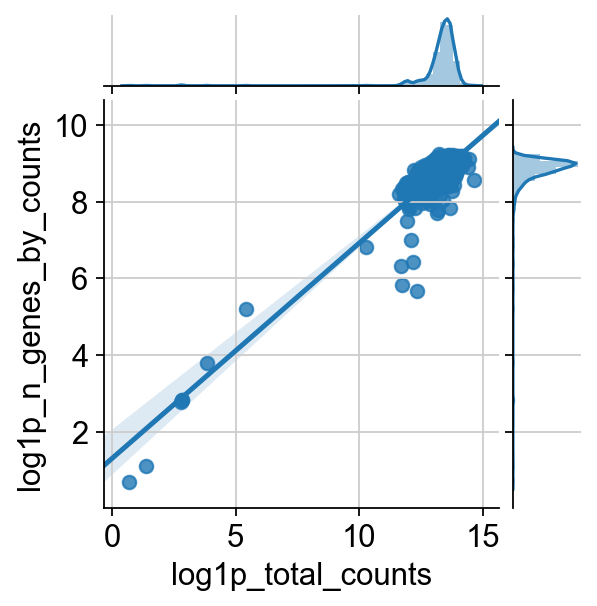

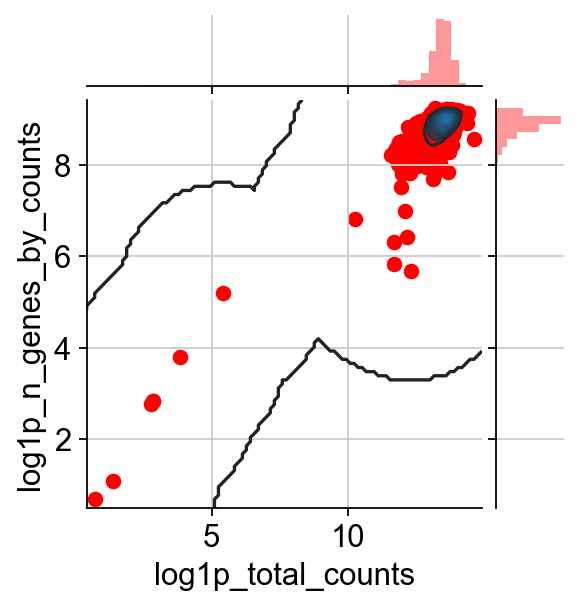

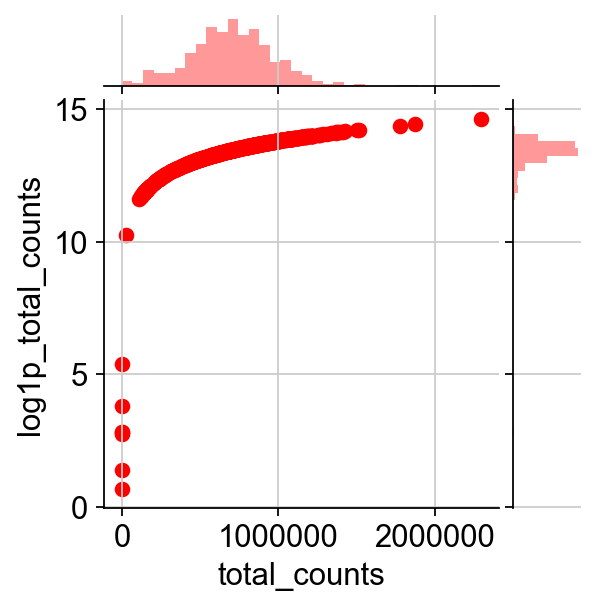

In [79]:
# Quality control metrics. If inplace = True, the output QC variables are added to adata.obs. If inplace = False,
# not included, only calculated and print.
sc.pp.calculate_qc_metrics(adata,inplace=True,percent_top=[50])
# Output
# n_genes_by_counts = Number of genes expressed
# log1p_n_genes_by_counts = (logX + 1)
# total_counts = Sum of counts for a gene
# pct_counts_in_top_50_genes = cumulative percentage of counts for 50 most most expressed genes. If deprecated, it 
# will estimate for a range of top genes.

#print(adata.obs)
sns.jointplot("log1p_total_counts","log1p_n_genes_by_counts",
            data=adata.obs,kind="reg",height=4)
sns.jointplot("log1p_total_counts","log1p_n_genes_by_counts",
            data=adata.obs,color="red",height=4).plot_joint(sns.kdeplot)
sns.jointplot("total_counts","log1p_total_counts",
            data=adata.obs,color="red",height=4)
adata

In [80]:
# Basic filtering
# Filtering cells and genes
# Cells with at least 2500 genes expressed
print(adata.n_obs)
sc.pp.filter_cells(adata,min_genes=2500)
# or alternatively:
#adata = adata[adata.obs['n_genes'] > 2500, :]
#print(adata.n_obs)
# In case we want to discard genes expressed in less than a minimum number of cells. In our case, only discard genes not expressed at all
sc.pp.filter_genes(adata,min_cells=1)
#Filter genes with a maximum number of counts
sc.pp.filter_cells(adata,min_counts=50000)
print(adata.n_obs)

860
filtered out 18 cells that haveless than 2500 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 15808 genes that are detectedin less than 1 cells


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


842


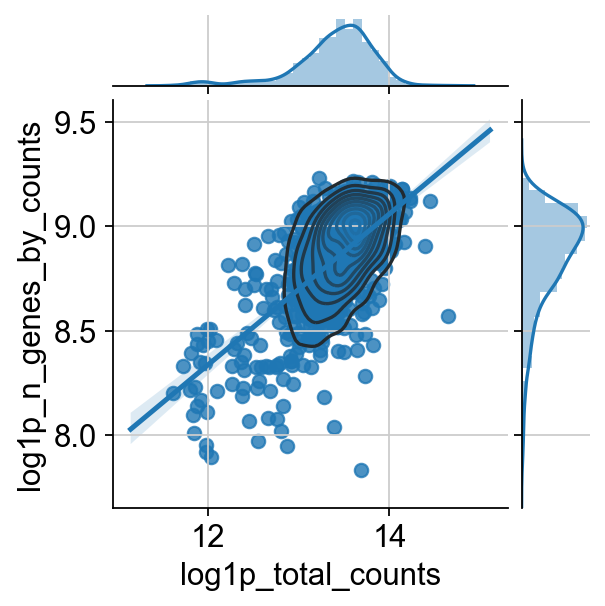

In [81]:
sns.jointplot("log1p_total_counts","log1p_n_genes_by_counts",
            data=adata.obs,kind="reg",height=4).plot_joint(sns.kdeplot)

:Scatter   [log1p_total_counts]   (log1p_n_genes_by_counts)

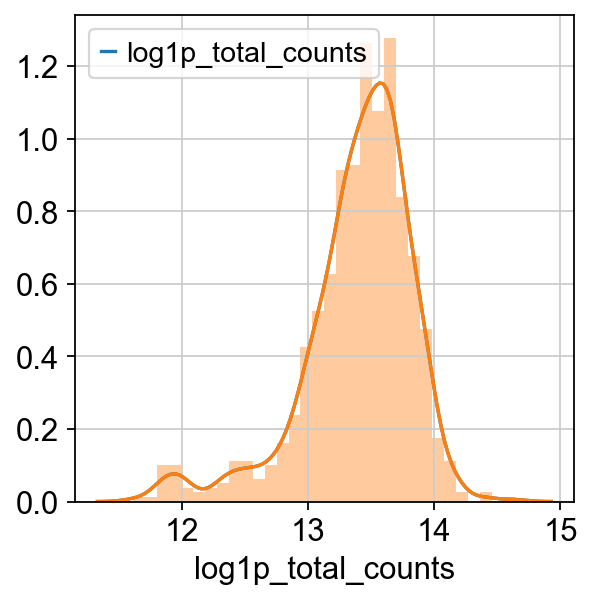

In [82]:
# Python histogram of gene expression levels
sns.kdeplot(adata.obs["log1p_total_counts"])
sns.distplot(adata.obs["log1p_total_counts"])
#adata.obs.hvplot.hexbin("log1p_total_counts", "log1p_n_genes_by_counts")
adata.obs.hvplot.hist("log1p_total_counts")
adata.obs.hvplot.hexbin("log1p_total_counts", "log1p_n_genes_by_counts")
adata.obs.hvplot.scatter(
    "log1p_total_counts",
    "log1p_n_genes_by_counts",
    dynspread=True
)

### Quality control for mitochondrial genes
#####  High proportions are indicative of poor-quality cells, possibly because of loss of cytoplasmatic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [83]:
adata.var

gene_ids   gene_symbols  n_cells_by_counts  \
gene_symbols                                                          
Gnai3          ENSMUSG00000000001          Gnai3                736   
Cdc45          ENSMUSG00000000028          Cdc45                432   
H19            ENSMUSG00000000031            H19                785   
Scml2          ENSMUSG00000000037          Scml2                189   
Apoh           ENSMUSG00000000049           Apoh                  1   
...                           ...            ...                ...   
RP24-246N21.1  ENSMUSG00000107383  RP24-246N21.1                791   
RP24-103L16.5  ENSMUSG00000107385  RP24-103L16.5                 21   
RP23-408A1.4   ENSMUSG00000107388   RP23-408A1.4                  3   
RP23-8L20.8    ENSMUSG00000107389    RP23-8L20.8                321   
RP24-351O18.4  ENSMUSG00000107390  RP24-351O18.4                 48   

               mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
gene_symbols                                                           
Gnai3            90.253487           4.513641              14.418605   
Cdc45            60.909302           4.125670              49.767442   
H19            1587.594238           7.370605               8.720930   
Scml2             3.739535           1.555939              78.023256   
Apoh              0.188372           0.172584              99.883721   
...                    ...                ...                    ...   
RP24-246N21.1    13.790698           2.693999               8.023256   
RP24-103L16.5     0.618605           0.481564              97.558140   
RP23-408A1.4      0.029070           0.028655              99.651163   
RP23-8L20.8       0.626744           0.486581              62.674419   
RP24-351O18.4     0.783721           0.578702              94.418605   

               total_counts  log1p_total_counts  n_cells  
gene_symbols                                              
Gnai3               77618.0           11.259567      735  
Cdc45               52382.0           10.866338      432  
H19               1365331.0           14.126908      777  
Scml2                3216.0            8.076204      189  
Apoh                  162.0            5.093750        1  
...                     ...                 ...      ...  
RP24-246N21.1       11860.0            9.381011      790  
RP24-103L16.5         532.0            6.278522       21  
RP23-408A1.4           25.0            3.258096        3  
RP23-8L20.8           539.0            6.291569      321  
RP24-351O18.4         674.0            6.514713       48  

[30362 rows x 9 columns]

In [84]:
# Only if gene symbols!
# In mice mitochondrial are mt- in human MT- or Mt, check!
mito_genes = adata.var_names.str.startswith('mt-')
#adata[:,mito_genes].var_names



# Similarly for ribosomal genes
#ribo_genes = adata.var_names.str.startswith('RP')
#adata[:,ribo_genes].var_names

# for each cell compute fraction of counts in mito genes vs. all genes
# the '.A1' is only necessary as X is sparse (to transform to a dense array after summing)

#axis=1 means accross columns
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
#adata.obs['percent_ribo'] = np.sum(adata[:,ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)


# add the total counts per cell as observations-annotation to adata after filtering steps
adata.obs['n_counts'] = adata.X.sum(axis=1)



... storing 'Time' as categorical
... storing 'Population' as categorical
... storing 'Batch_name' as categorical
... storing 'Plate_well' as categorical
... storing 'Phase' as categorical
... storing 'gene_symbols' as categorical


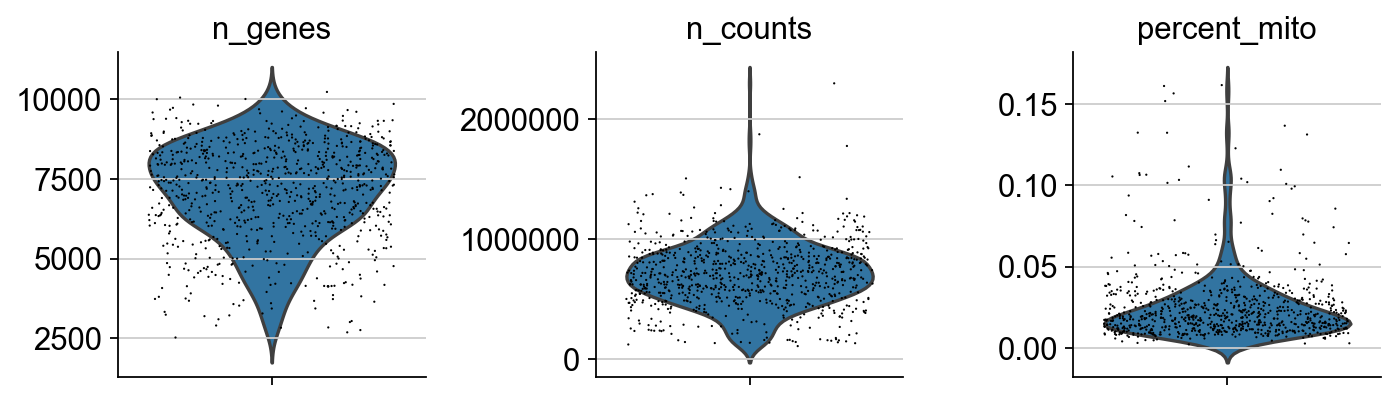

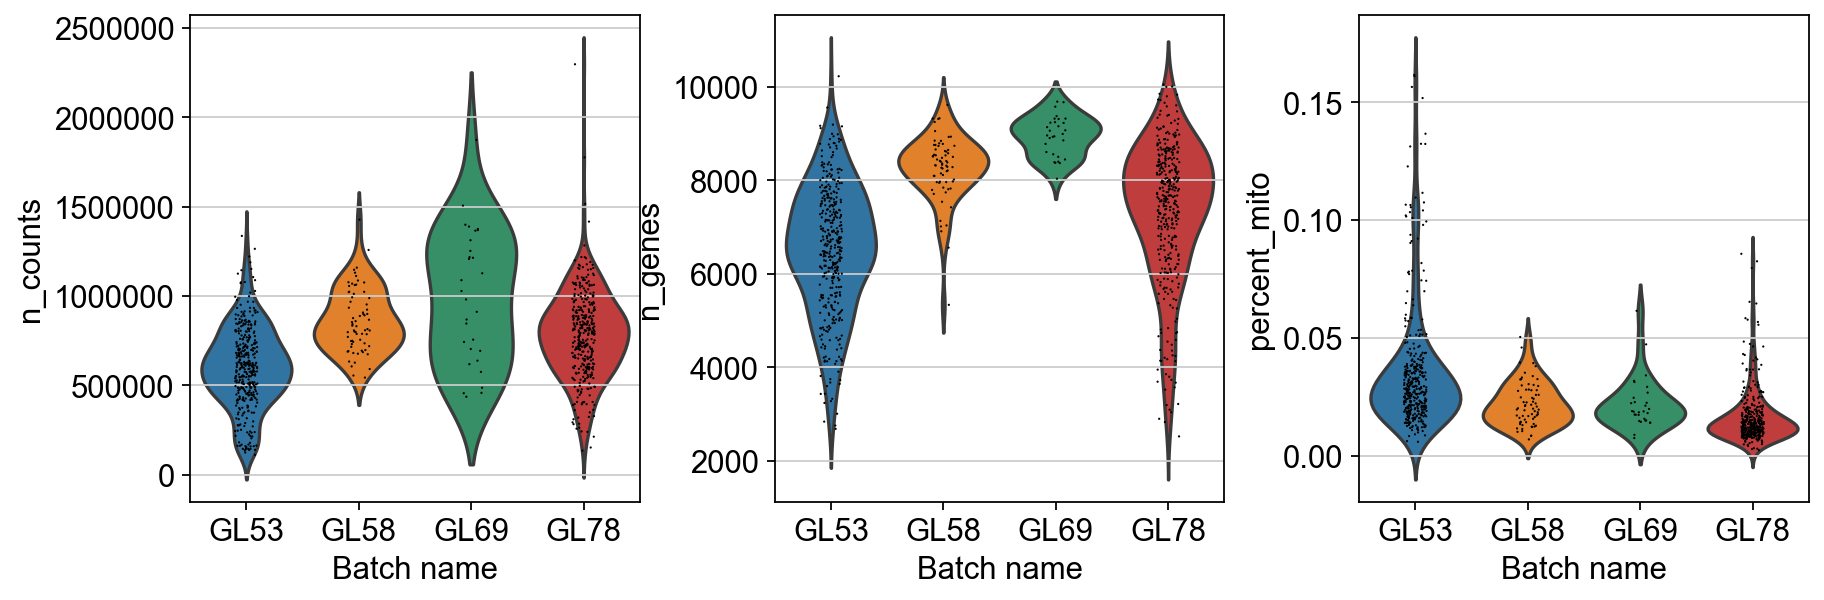

In [85]:
# A violin plot of the computed quality measures
# Plot in the same panel
#sc.pl.violin(adata,['n_genes','n_counts','percent_mito'],
#            jitter=0.4,multi_panel=False)

# Plot in different panel (as facet in R)
sc.pl.violin(adata,['n_genes','n_counts','percent_mito'],
            jitter=0.4,multi_panel=True)

#n_counts and genes by Phase
sc.pl.violin(adata, ['n_counts','n_genes','percent_mito'], groupby='Batch_name')

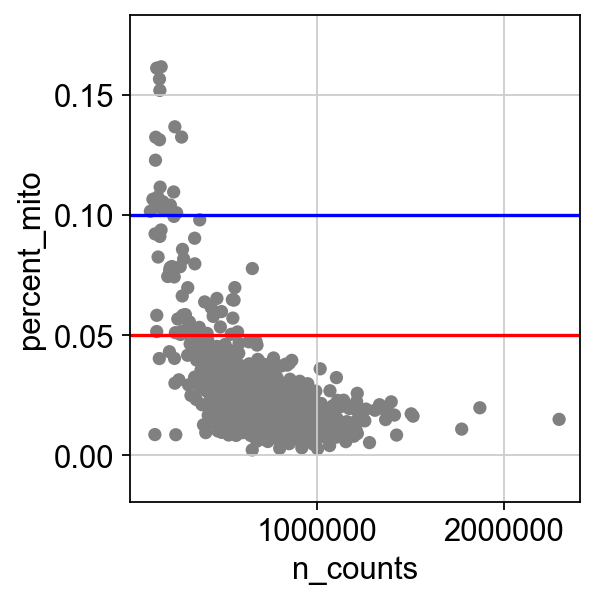

In [86]:
ax = sc.pl.scatter(adata, x='n_counts', y='percent_mito', show=False)
ax.axhline(y=0.05, c='red')
ax.axhline(y=0.1, c='blue')

In [87]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts
#sc.pl.scatter(adata, x='n_counts', y='percent_mito')
#sc.pl.scatter(adata, x='n_counts',y='n_genes')
#adata

# Keep cells with less than 5% mithochondrial genes expressed.
print(adata)
adata = adata[adata.obs['percent_mito'] < 0.05, :]

print(adata)

AnnData object with n_obs × n_vars = 842 × 30362 
    obs: 'Time', 'Population', 'Batch', 'Batch_name', 'Plate_well', 'DLL4', 'NOTCH2', 'CKIT', 'GFI1', 'CD41', 'NOTCH1', 'CD31', 'JAG1', 'CD45', 'Phase', 'G1', 'G2M', 'S', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
View of AnnData object with n_obs × n_vars = 775 × 30362 
    obs: 'Time', 'Population', 'Batch', 'Batch_name', 'Plate_well', 'DLL4', 'NOTCH2', 'CKIT', 'GFI1', 'CD41', 'NOTCH1', 'CD31', 'JAG1', 'CD45', 'Phase', 'G1', 'G2M', 'S', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'l

#### TOTAL FILTERED CELLS = 775 (90%)

In [88]:
# Normalization by scanpy. The sum of all counts will be 1000. See manual for other parameters.
#print(adata.X)
sc.pp.normalize_total(adata, target_sum=1e4)

# And now, logarithmize the data
sc.pp.log1p(adata)

Normalizing counts per cell.
    finished (0:00:00):normalized adata.X


/Users/yolanda_guillen/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [89]:
# Now set the .raw attribute of adata to the logarithmized raw gene expresseion for later use. This freezes the state
# of adata object.
# adata.raw -- Store raw version of X and var as .raw.X and .raw.var.
# Its content can be deleted by setting it back to None: adata.raw = None
# To retrieve the data associated with a variable that might have been filtered out or "compressed away" in X:
# adata.raw[:, 'orig_variable_name'].X
adata.raw = adata

In [90]:
# Highest expressed genes
sc.pl.highest_expr_genes(adata, n_top=50)

normalizing by total count per cell


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


ValueError: cannot reindex from a duplicate axis

/Users/yolanda_guillen/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


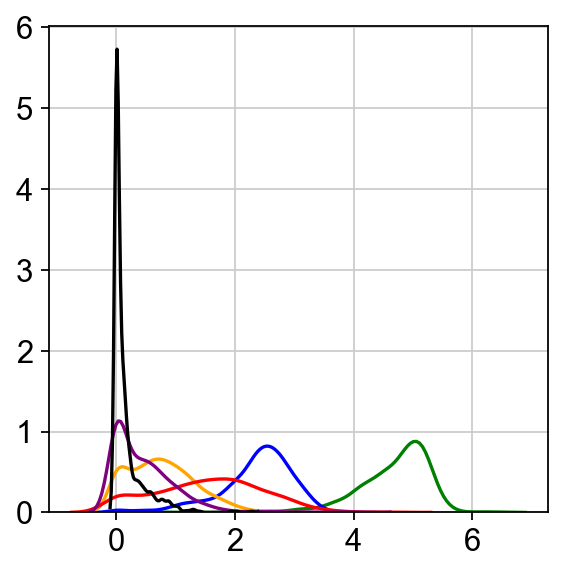

In [91]:
# Check the distribution of some genes in all samples to compare highly expressed genes.
gene0 = adata.raw[:, 'Actb'].X
gene1 = adata.raw[:, 'Ctnnb1'].X
gene2 = adata.raw[:, 'Notch1'].X
gene5 = adata.raw[:, 'Notch2'].X
gene3 = adata.raw[:, 'Klf6'].X
gene4 = adata.raw[:, 'Gata2'].X
sns.kdeplot(gene0,color="green")
sns.kdeplot(gene1,color="blue")
sns.kdeplot(gene2,color="orange")
sns.kdeplot(gene3,color="red")
sns.kdeplot(gene4,color="purple")
sns.kdeplot(gene5,color="black")

### Identify highly-variable genes

In [92]:
# Expects logarithmized data.
# The normalized dispersion is obtained by scaling with the mean and standard deviation of the
# dispersions for genes falling into a given bin for mean expression of genes. This means that
# for each bin of mean expression, highly variable genes are selected.

# values by default
sc.pp.highly_variable_genes(adata,
                            min_mean = 0.0125,
                           max_mean = 3,
                           min_disp= 0.5)
# from this point, if we want to plot gene counts distribution, we need to use adata.raw X matrix

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


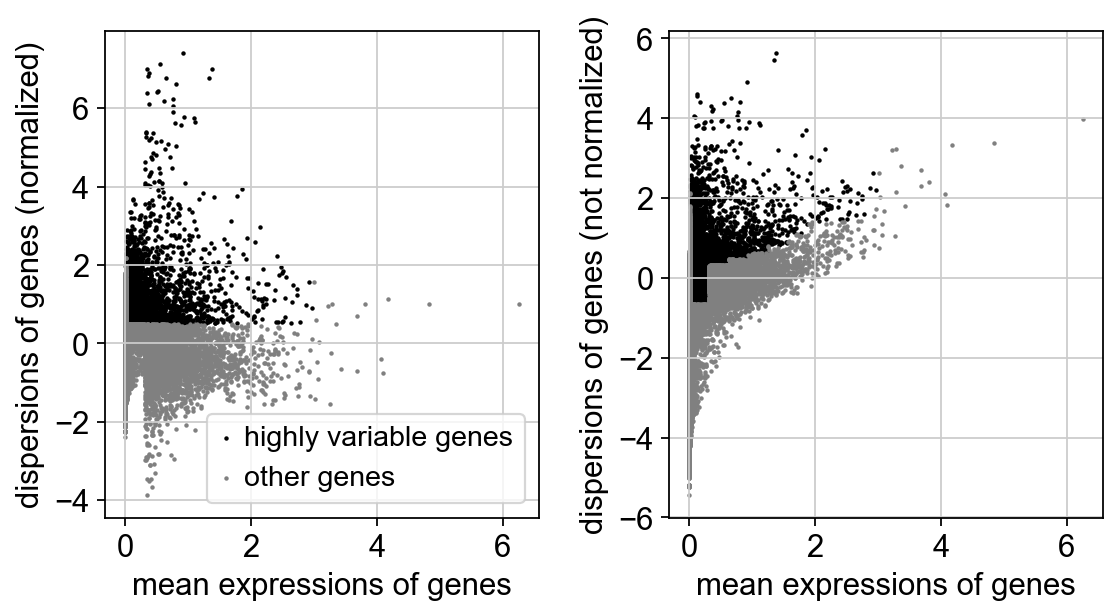

In [93]:
# Plot
sc.pl.highly_variable_genes(adata)

#### Top expressed genes: Ribosomal (they shouldn't be there since only polyA RNA was isolated) and mitochondrial genes (mt-) which means that cells were injured during isolation/treatment/experiment

In [94]:
adata.var

gene_ids   gene_symbols  n_cells_by_counts  \
gene_symbols                                                          
Gnai3          ENSMUSG00000000001          Gnai3                736   
Cdc45          ENSMUSG00000000028          Cdc45                432   
H19            ENSMUSG00000000031            H19                785   
Scml2          ENSMUSG00000000037          Scml2                189   
Apoh           ENSMUSG00000000049           Apoh                  1   
...                           ...            ...                ...   
RP24-246N21.1  ENSMUSG00000107383  RP24-246N21.1                791   
RP24-103L16.5  ENSMUSG00000107385  RP24-103L16.5                 21   
RP23-408A1.4   ENSMUSG00000107388   RP23-408A1.4                  3   
RP23-8L20.8    ENSMUSG00000107389    RP23-8L20.8                321   
RP24-351O18.4  ENSMUSG00000107390  RP24-351O18.4                 48   

               mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
gene_symbols                                                           
Gnai3            90.253487           4.513641              14.418605   
Cdc45            60.909302           4.125670              49.767442   
H19            1587.594238           7.370605               8.720930   
Scml2             3.739535           1.555939              78.023256   
Apoh              0.188372           0.172584              99.883721   
...                    ...                ...                    ...   
RP24-246N21.1    13.790698           2.693999               8.023256   
RP24-103L16.5     0.618605           0.481564              97.558140   
RP23-408A1.4      0.029070           0.028655              99.651163   
RP23-8L20.8       0.626744           0.486581              62.674419   
RP24-351O18.4     0.783721           0.578702              94.418605   

               total_counts  log1p_total_counts  n_cells  highly_variable  \
gene_symbols                                                                
Gnai3               77618.0           11.259567      735            False   
Cdc45               52382.0           10.866338      432             True   
H19               1365331.0           14.126908      777            False   
Scml2                3216.0            8.076204      189            False   
Apoh                  162.0            5.093750        1            False   
...                     ...                 ...      ...              ...   
RP24-246N21.1       11860.0            9.381011      790            False   
RP24-103L16.5         532.0            6.278522       21            False   
RP23-408A1.4           25.0            3.258096        3            False   
RP23-8L20.8           539.0            6.291569      321            False   
RP24-351O18.4         674.0            6.514713       48            False   

                  means  dispersions  dispersions_norm  
gene_symbols                                            
Gnai3          0.843630     0.063677         -0.153228  
Cdc45          0.615760     0.523255          0.811283  
H19            3.226932     3.207336          0.956751  
Scml2          0.051940    -0.779743          0.427197  
Apoh           0.002362     0.605994          1.265500  
...                 ...          ...               ...  
RP24-246N21.1  0.171873    -2.359275         -0.528343  
RP24-103L16.5  0.010330    -0.384387          0.666368  
RP23-408A1.4   0.000456    -1.040347          0.269544  
RP23-8L20.8    0.008387    -3.966990         -1.500932  
RP24-351O18.4  0.005454     0.579411          1.249419  

[30362 rows x 13 columns]

In [95]:

# highly_variable is now a boolean variable (adata.var) indicating whether a gene is considered highly variable (True),
# or not (False)


# Selecting only highly_variable genes
adata = adata[:, adata.var['highly_variable']]
adata.var

# Check that now all values of highly_variable are True

gene_ids   gene_symbols  n_cells_by_counts  \
gene_symbols                                                          
Cdc45          ENSMUSG00000000028          Cdc45                432   
Narf           ENSMUSG00000000056           Narf                496   
Cav2           ENSMUSG00000000058           Cav2                430   
Klf6           ENSMUSG00000000078           Klf6                780   
Scmh1          ENSMUSG00000000085          Scmh1                480   
...                           ...            ...                ...   
Mpv17          ENSMUSG00000107283          Mpv17                563   
RP24-122N24.2  ENSMUSG00000107286  RP24-122N24.2                 88   
RP24-544J6.5   ENSMUSG00000107336   RP24-544J6.5                 90   
BX510318.1     ENSMUSG00000107338     BX510318.1                 35   
RP24-80F7.3    ENSMUSG00000107352    RP24-80F7.3                 51   

               mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
gene_symbols                                                           
Cdc45            60.909302           4.125670              49.767442   
Narf             38.283722           3.670810              42.325581   
Cav2             22.733721           3.166897              50.000000   
Klf6            418.913940           6.040050               9.302326   
Scmh1            24.325581           3.231815              44.186047   
...                    ...                ...                    ...   
Mpv17            24.954651           3.256351              34.534884   
RP24-122N24.2     1.691860           0.990233              89.767442   
RP24-544J6.5      1.808140           1.032522              89.534884   
BX510318.1        1.426744           0.886551              95.930233   
RP24-80F7.3       1.074419           0.729681              94.069767   

               total_counts  log1p_total_counts  n_cells  highly_variable  \
gene_symbols                                                                
Cdc45               52382.0           10.866338      432             True   
Narf                32924.0           10.401987      496             True   
Cav2                19551.0            9.880833      430             True   
Klf6               360266.0           12.794600      775             True   
Scmh1               20920.0            9.948508      480             True   
...                     ...                 ...      ...              ...   
Mpv17               21461.0            9.974039      562             True   
RP24-122N24.2        1455.0            7.283448       87             True   
RP24-544J6.5         1555.0            7.349874       90             True   
BX510318.1           1227.0            7.113142       35             True   
RP24-80F7.3           924.0            6.829794       51             True   

                  means  dispersions  dispersions_norm  
gene_symbols                                            
Cdc45          0.615760     0.523255          0.811283  
Narf           0.449290     0.342546          0.515180  
Cav2           0.286946     0.003488          0.901013  
Klf6           1.945916     2.260241          1.655785  
Scmh1          0.301395    -0.090000          0.844458  
...                 ...          ...               ...  
Mpv17          0.309559    -0.432557          0.637227  
RP24-122N24.2  0.023300    -0.273410          0.733503  
RP24-544J6.5   0.027230    -0.458520          0.621521  
BX510318.1     0.019374    -0.020089          0.886750  
RP24-80F7.3    0.018487    -0.619058          0.524404  

[7925 rows x 13 columns]

In [96]:
print(adata)
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Also regress out for
# cell cycle numerical scores 
sc.pp.regress_out(adata, ['n_counts','percent_mito','Batch','S','G2M'])
# no cell cycle regress
#sc.pp.regress_out(adata, ['n_counts','percent_mito'])

View of AnnData object with n_obs × n_vars = 775 × 7925 
    obs: 'Time', 'Population', 'Batch', 'Batch_name', 'Plate_well', 'DLL4', 'NOTCH2', 'CKIT', 'GFI1', 'CD41', 'NOTCH1', 'CD31', 'JAG1', 'CD45', 'Phase', 'G1', 'G2M', 'S', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
regressing out ['n_counts', 'percent_mito', 'Batch', 'S', 'G2M']


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


    finished (0:00:23)


In [97]:
# Now scale each gene to unit variance. Clip values exceeding standard deviation 10
sc.pp.scale(adata, max_value = 10)

## VISUALIZATION 

### Simplest multidimensional representation = PCA
#### Clusters will be infered later using UMAP from PCs in PCA

In [98]:


# tl is for tools, pp was for preprocessing
sc.tl.pca(adata)



Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


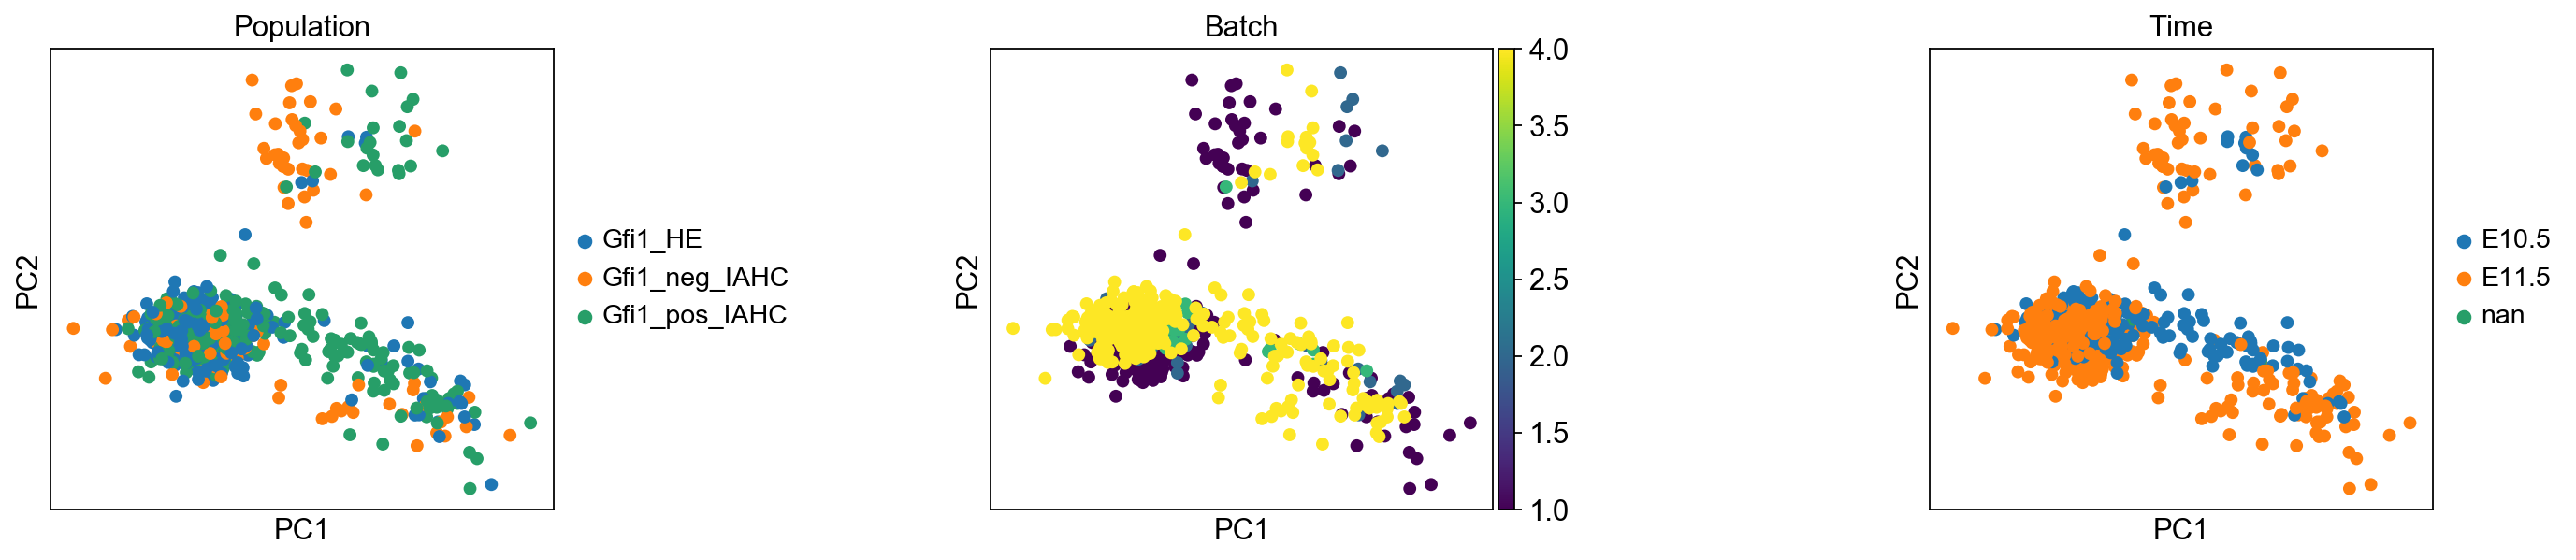

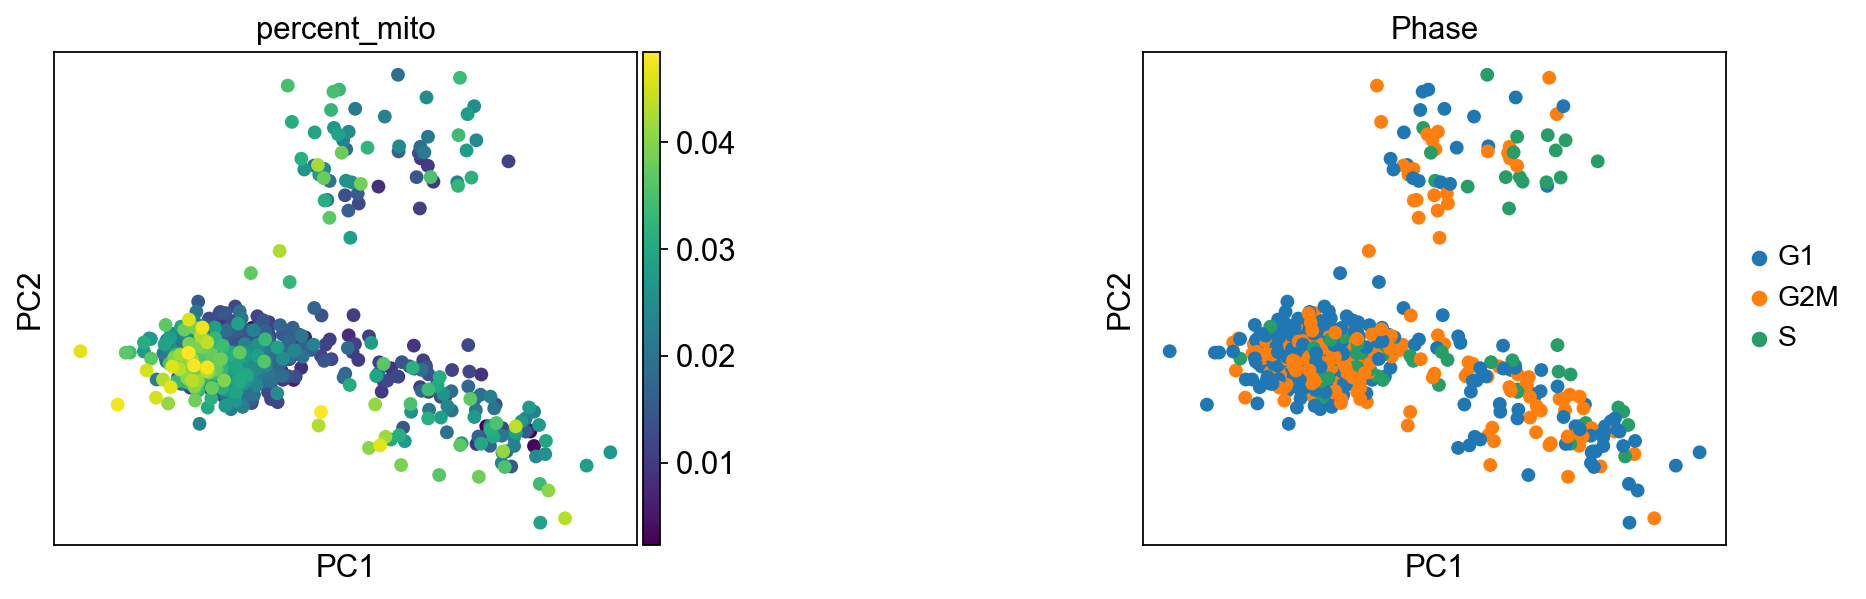

In [99]:
sc.pl.pca_scatter(adata, color=['Population','Batch','Time'], wspace=0.7)
sc.pl.pca_scatter(adata, color=['percent_mito','Phase'], wspace=0.7)

##### Color by marker protein and its corresponding gene

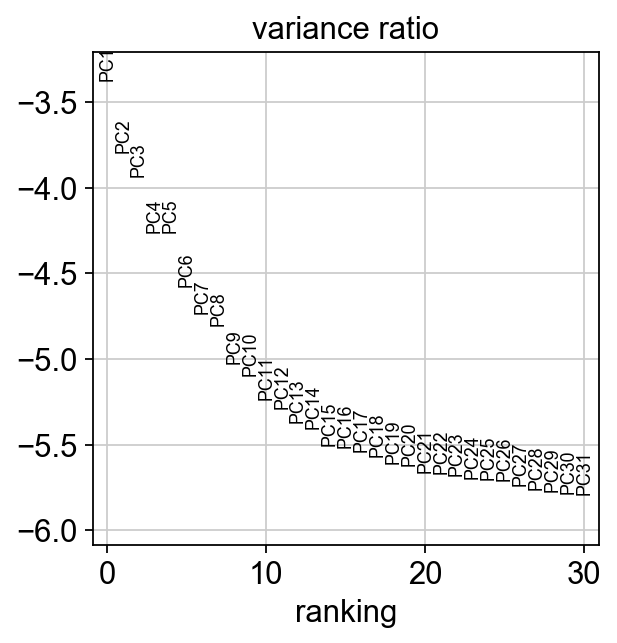

In [100]:
# Estimation of the contribution of single PCs to the total variance in the data. This gives us information
# about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in
# the clustering function sc.tl.louvain() or tSNE sc.tl.tsne. In our experience, often, a rough estmiate of the
# number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)


In [ ]:

# Save the result
# Results wil be saved in scRNA_AGM.h5ad (previously defined)
adata.write(results_file)

In [101]:
adata

AnnData object with n_obs × n_vars = 775 × 7925 
    obs: 'Time', 'Population', 'Batch', 'Batch_name', 'Plate_well', 'DLL4', 'NOTCH2', 'CKIT', 'GFI1', 'CD41', 'NOTCH1', 'CD31', 'JAG1', 'CD45', 'Phase', 'G1', 'G2M', 'S', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'Population_colors', 'Time_colors', 'Phase_colors'
    obsm: 'X_pca'
    varm: 'PCs'

### UMAP Computation

In [102]:
## Computing the neighborhood graph

# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix.
# You might simply use default values here. For the sake of reproducing Seurat's results, let's take
# the following values.

sc.pp.neighbors(adata, n_neighbors = 5)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)


In [103]:
sc.tl.umap(adata,n_components=2)

computing UMAP


/Users/yolanda_guillen/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:01)


In [104]:
adata.obsm['X_umap'].shape

(775, 2)

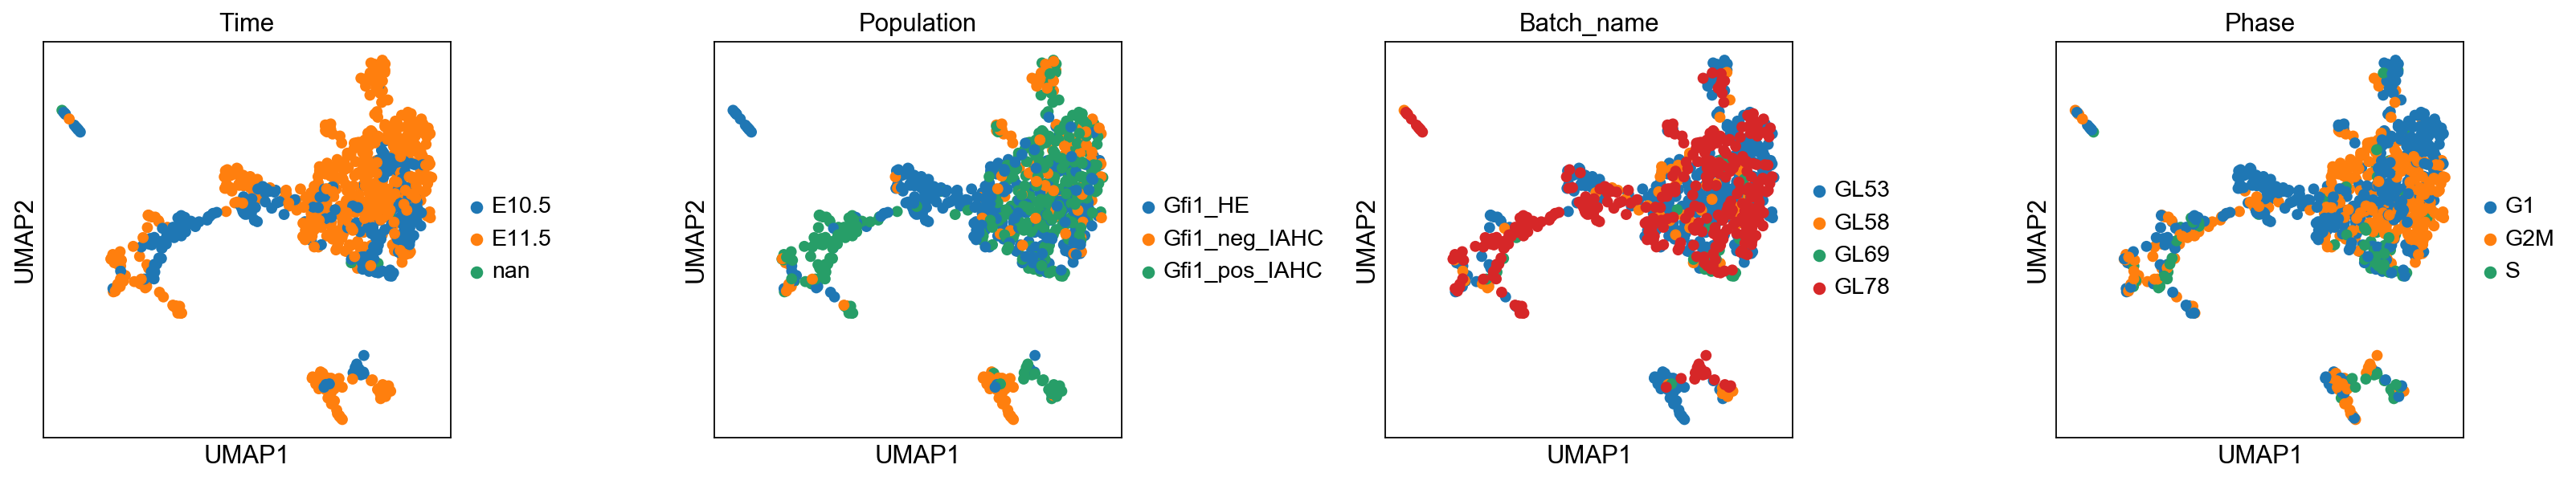

In [105]:
sc.pl.umap(adata, color=['Time', 'Population','Batch_name','Phase'],use_raw=False, wspace=0.5, components=[1,2])

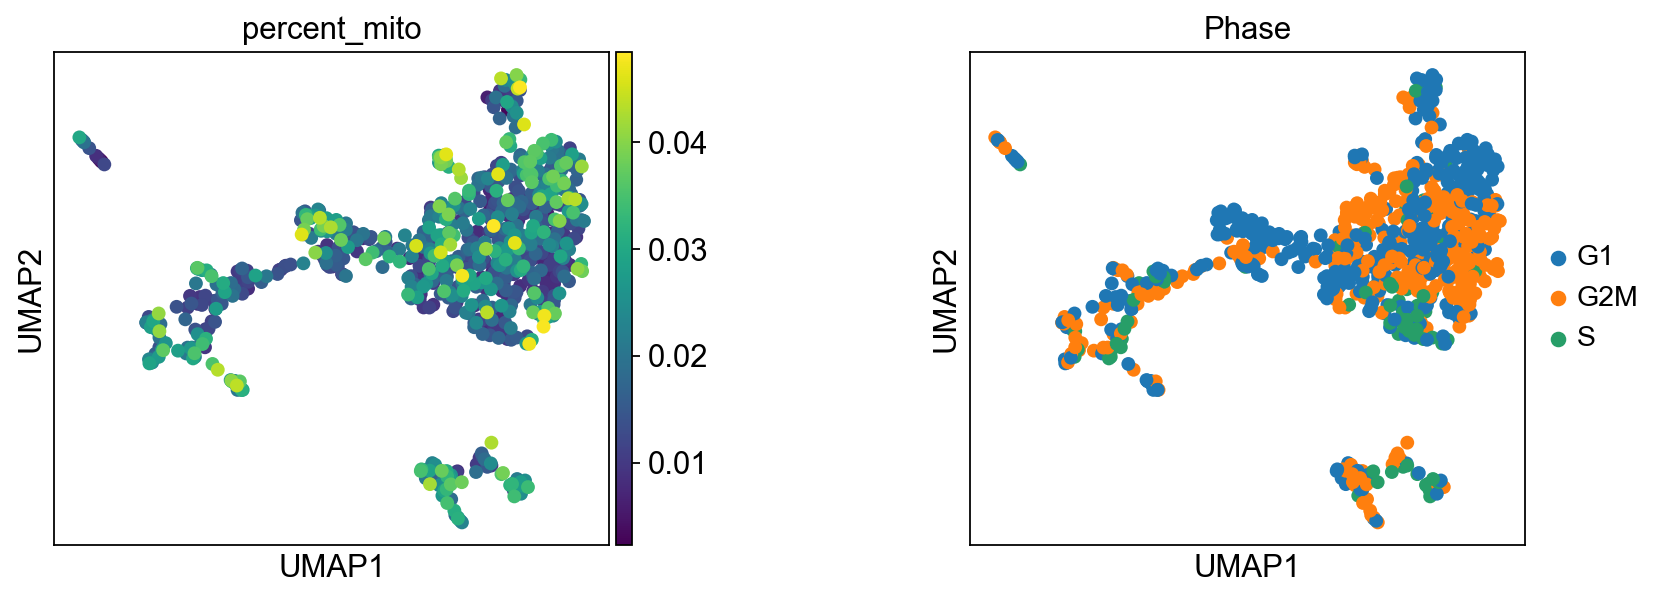

In [106]:
sc.pl.umap(adata, color=['percent_mito','Phase'],use_raw=False, wspace=0.5)

#### CLUSTERING THE NEIGHBORHOOD GRAPHS

In [107]:

# As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based method based
# on optimazing modularity). It has been proposed for single-cell data by Levite et al. 2015. Louvain clustering
# directly clusters the neighborhood graph of cells, which we already computed in the previous section

# With louvain we identify different clusters based on UMAP
# Reducing resolution, we reduce the number of different clusters
sc.tl.louvain(adata, resolution = 0.4, random_state=0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [108]:
rawadata=adata

#### Number of Clusters

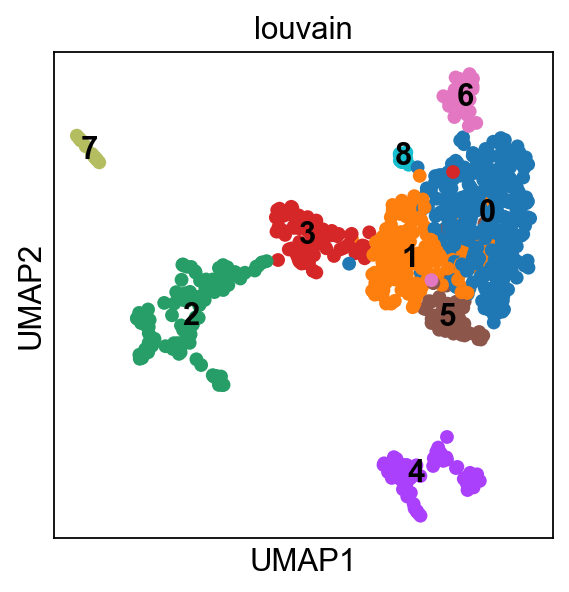

In [109]:
sc.pl.umap(adata, color=['louvain'], wspace=0.5, legend_loc='on data')

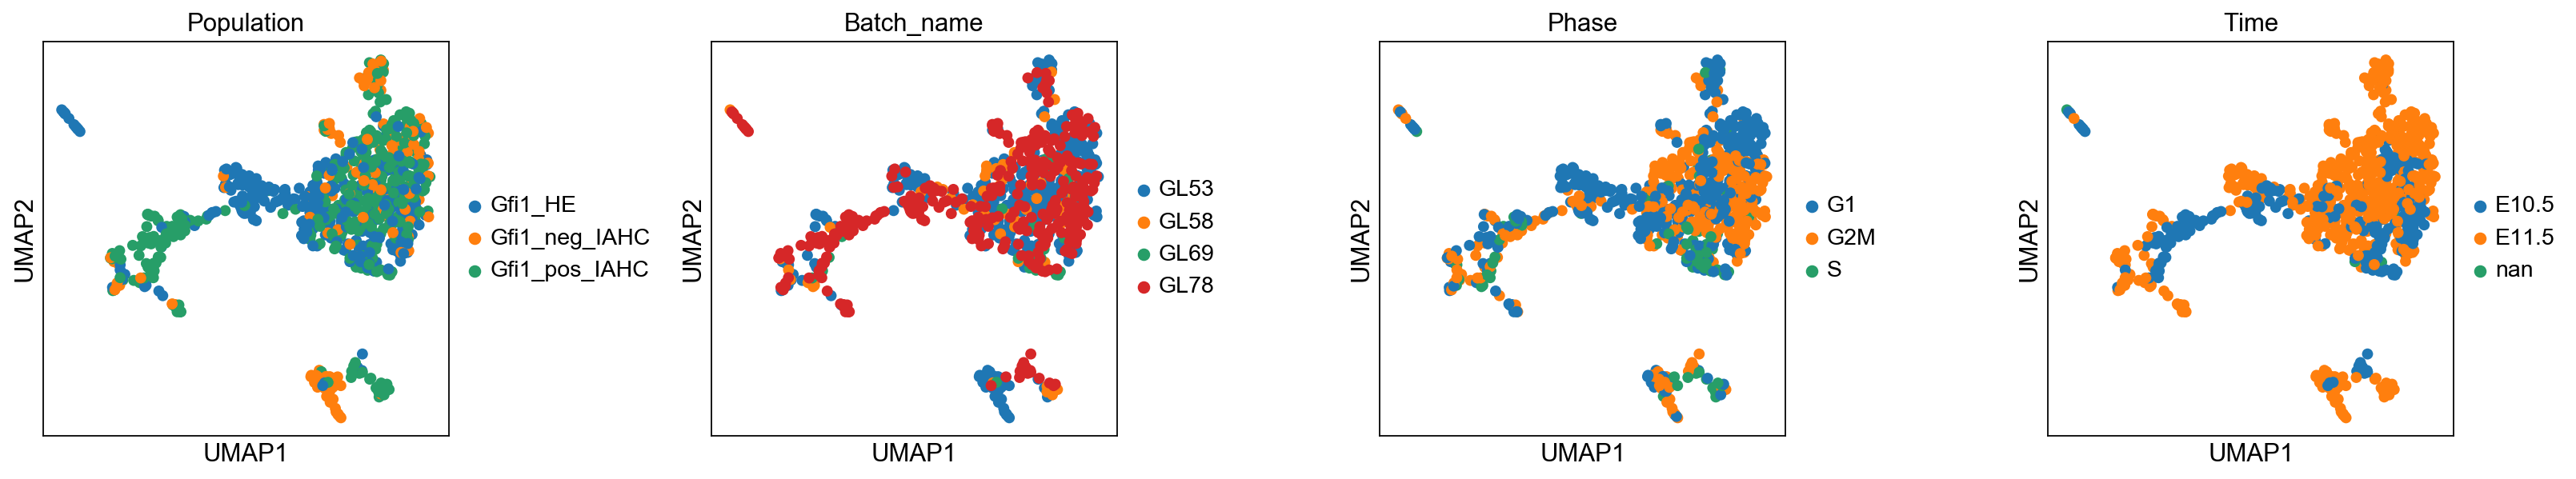

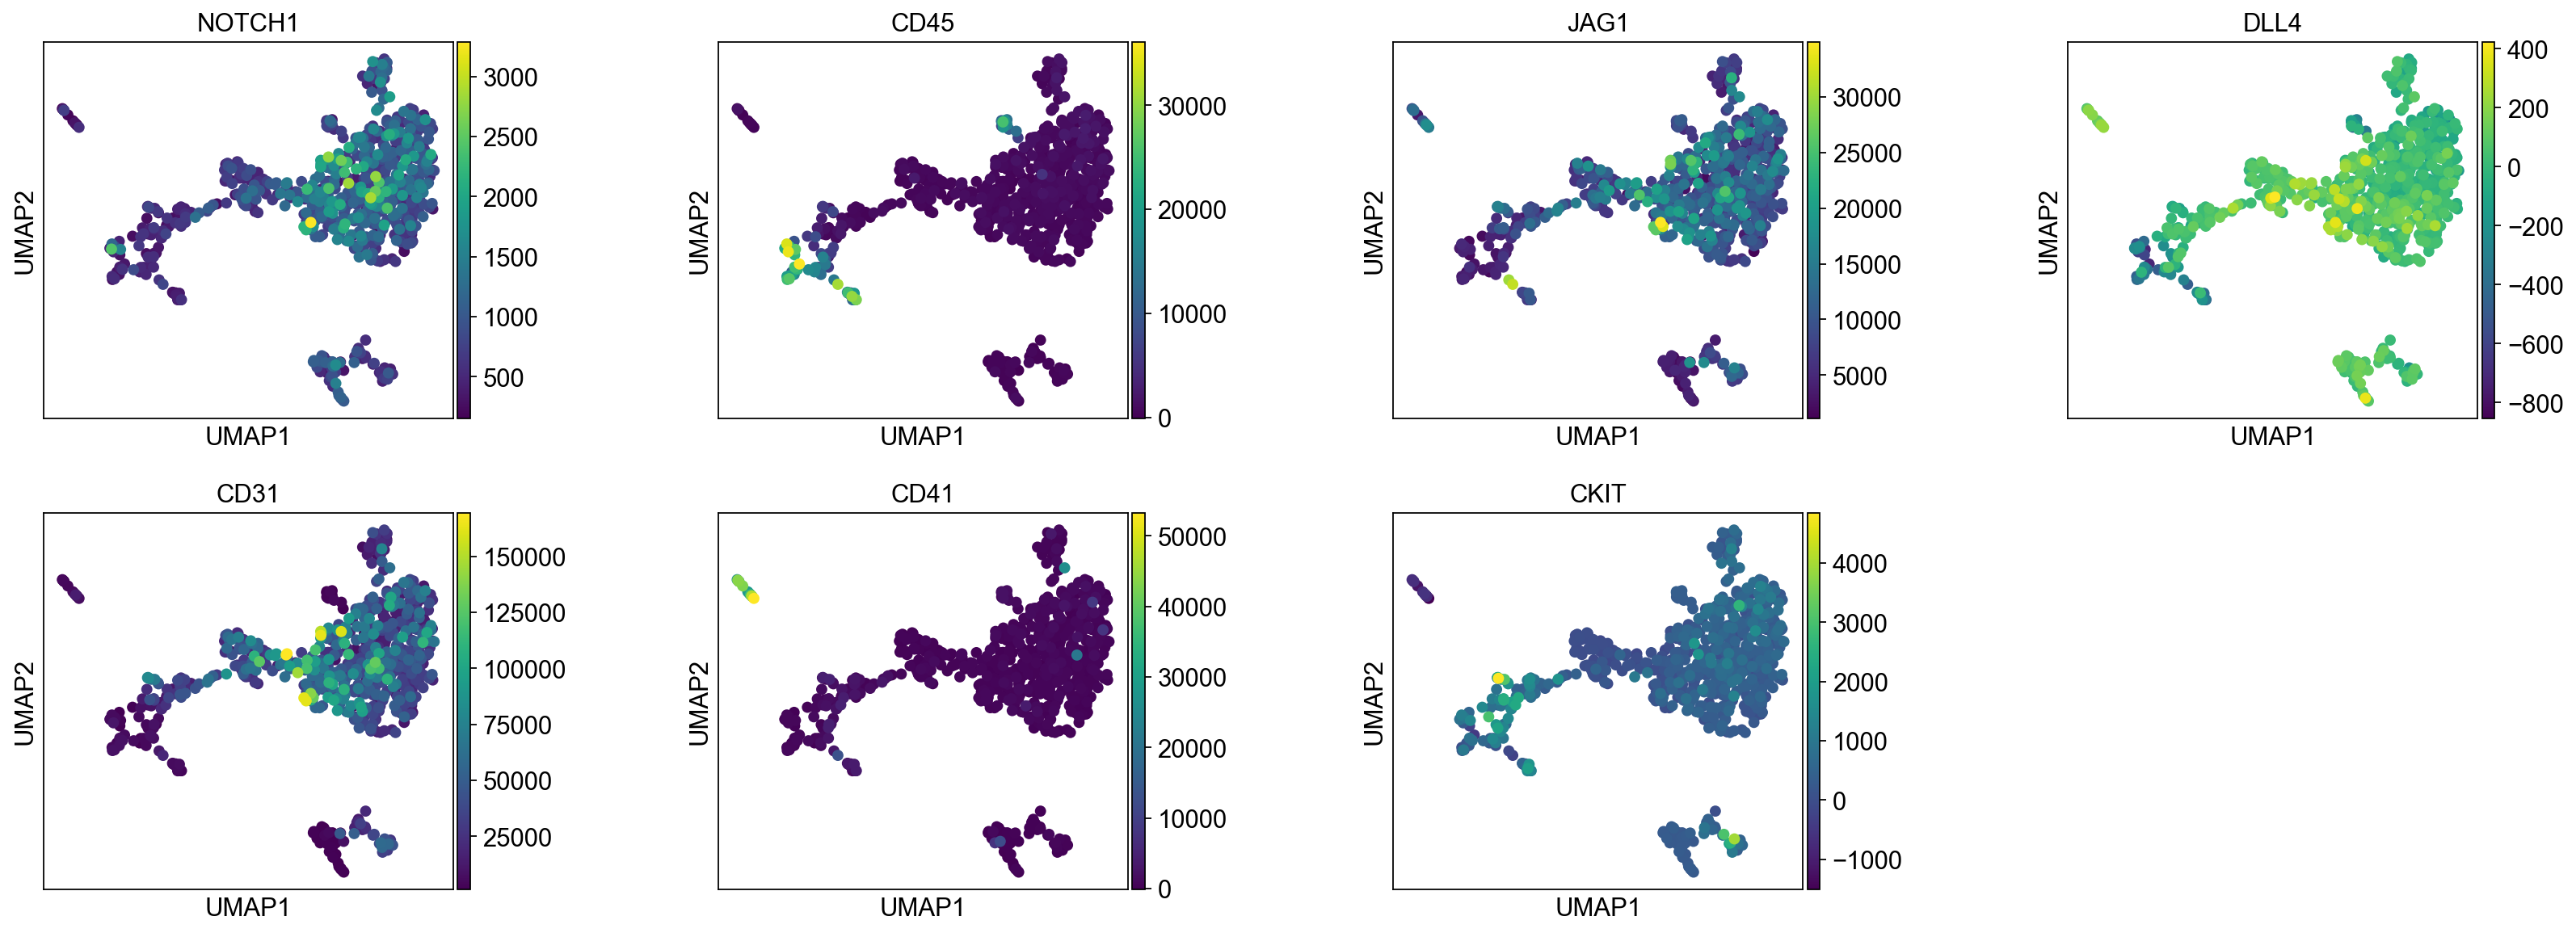

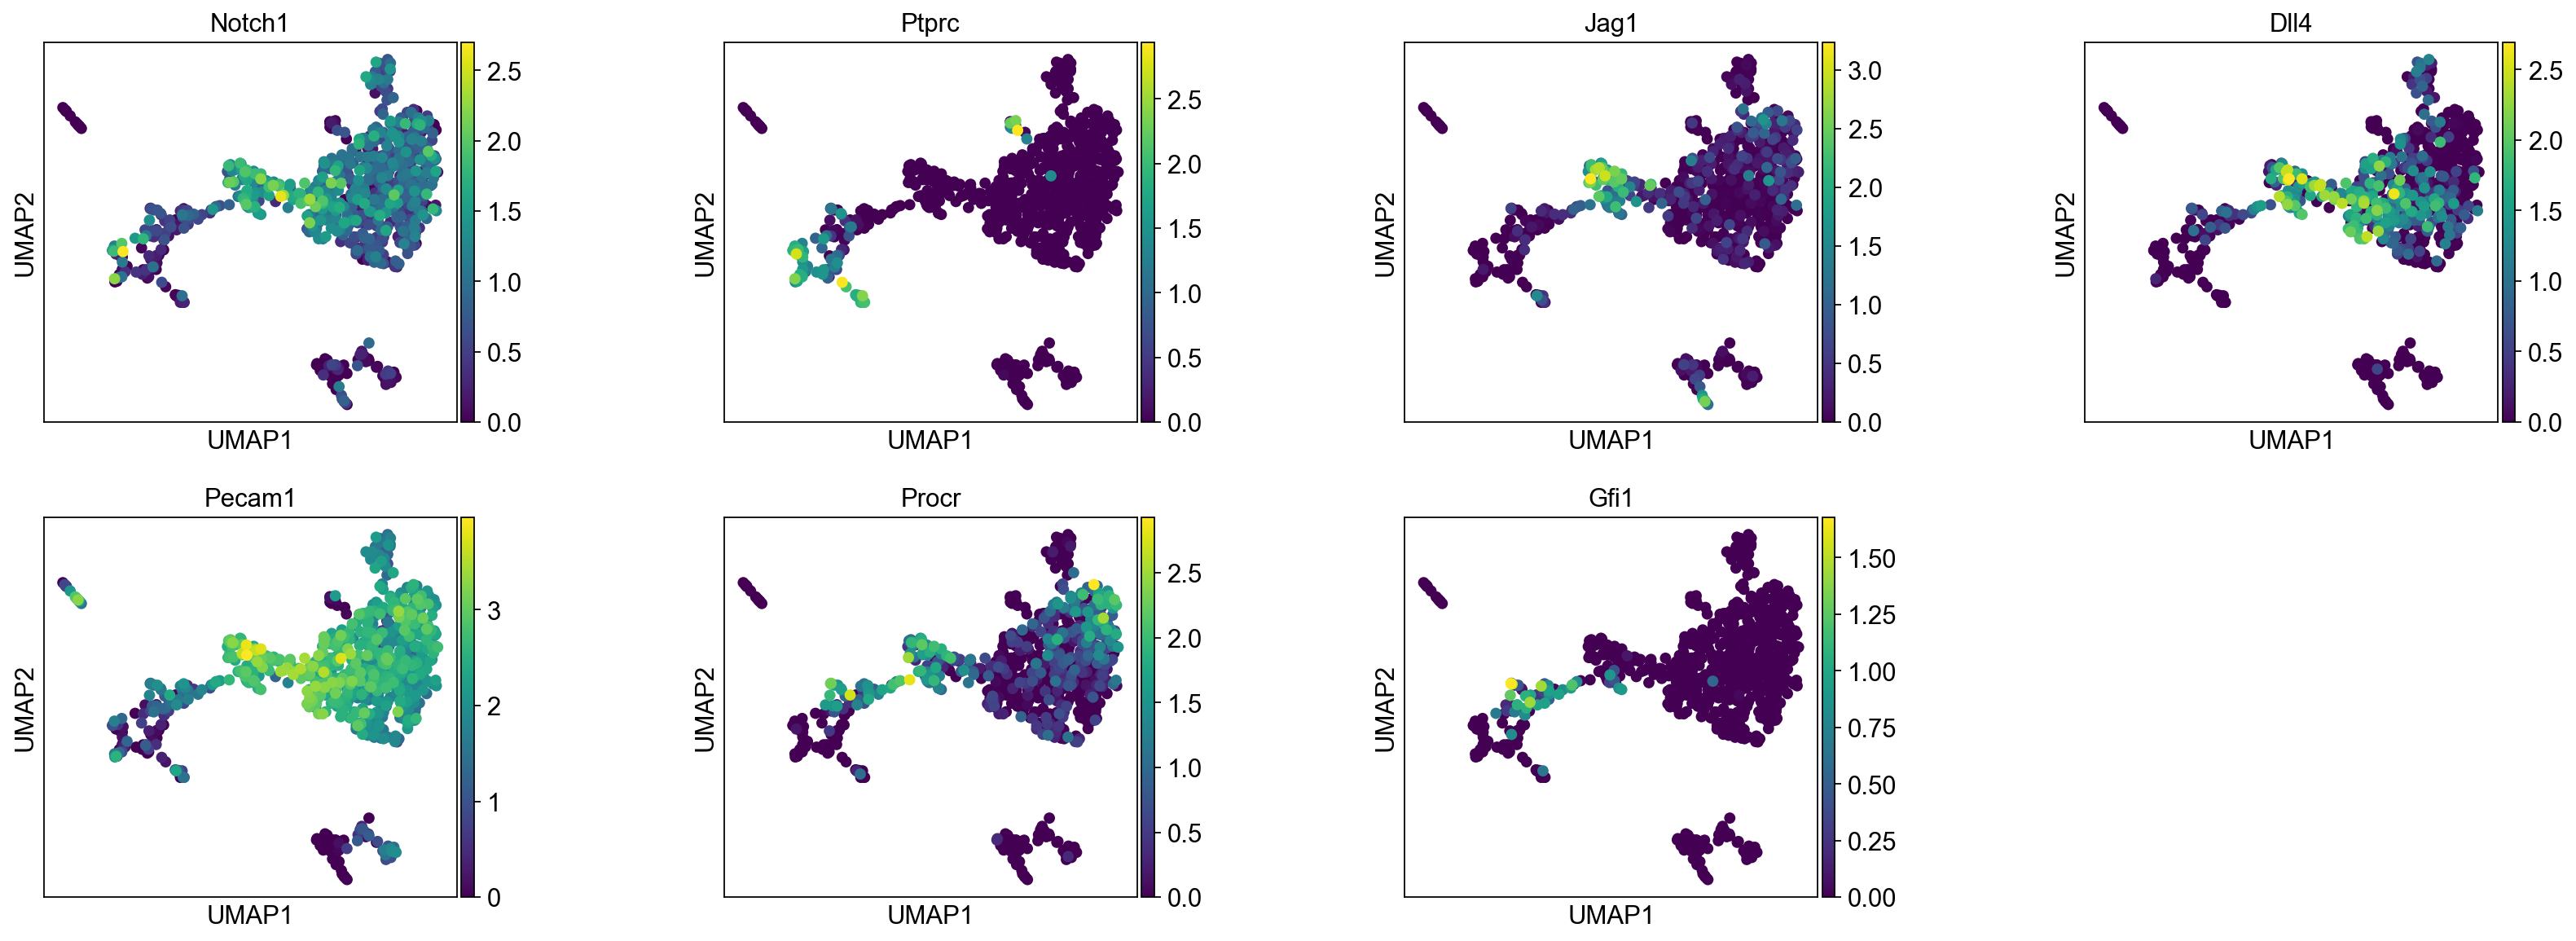

In [110]:
sc.pl.umap(adata, color=['Population','Batch_name','Phase','Time'], wspace=0.5)
sc.pl.umap(adata, color=['NOTCH1','CD45','JAG1','DLL4','CD31','CD41','CKIT'], wspace=0.5)
sc.pl.umap(adata, color=['Notch1','Ptprc','Jag1','Dll4','Pecam1','Procr','Gfi1'], wspace=0.5)

In [112]:
# Subset cells by cluster (HE)
k3=adata[adata.obs['louvain'] ==  '3']
print(k3)

View of AnnData object with n_obs × n_vars = 76 × 7925 
    obs: 'Time', 'Population', 'Batch', 'Batch_name', 'Plate_well', 'DLL4', 'NOTCH2', 'CKIT', 'GFI1', 'CD41', 'NOTCH1', 'CD31', 'JAG1', 'CD45', 'Phase', 'G1', 'G2M', 'S', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts', 'percent_mito', 'louvain'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'Population_colors', 'Time_colors', 'Phase_colors', 'neighbors', 'Batch_name_colors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


In [118]:
# Rank genes by louvain group
sc.tl.rank_genes_groups(k3,groupby='Time')

ranking genes
    finished (0:00:00)


In [119]:
k3.uns_keys()

['Batch_name_colors',
 'Phase_colors',
 'Population_colors',
 'Time_colors',
 'louvain',
 'louvain_colors',
 'neighbors',
 'pca',
 'rank_genes_groups']

In [120]:
pd.DataFrame(k3.uns['rank_genes_groups']['names']).head(30)

E10.5          E11.5
0   Rps2-ps13          Ptprb
1       Gapdh          Fbln5
2   Rpsa-ps10           Cav1
3      Gm8730          Ltbp4
4       Rps29        Gm10263
5        Ppia           Clk1
6       Rpl19           Cdh5
7       Rpl34         Malat1
8     Gm13394          Htra1
9        Rps8           Bpgm
10     Rpl10a         mt-Co1
11      Rps10           Lmo2
12     Tmsb10          Fstl1
13      Rpl27      Rps19-ps8
14      Rps28         mt-Nd4
15      Rps19            Eln
16        Fau          Rbm39
17      Rps13        Gm10269
18      Rpl36          Nfat5
19      Rps26         Lrrc8a
20      Rpl13  RP23-263B18.4
21      Rps23          Ltbp3
22      Rplp1        Gm10268
23      Rps16         Stard9
24      Rplp2        mt-Rnr1
25      Rpl38           Nfia
26    Gm10076         Adam10
27      Rplp0          Fbln2
28      Rpl18      Rps24-ps3
29      Rpl11           Dkk2

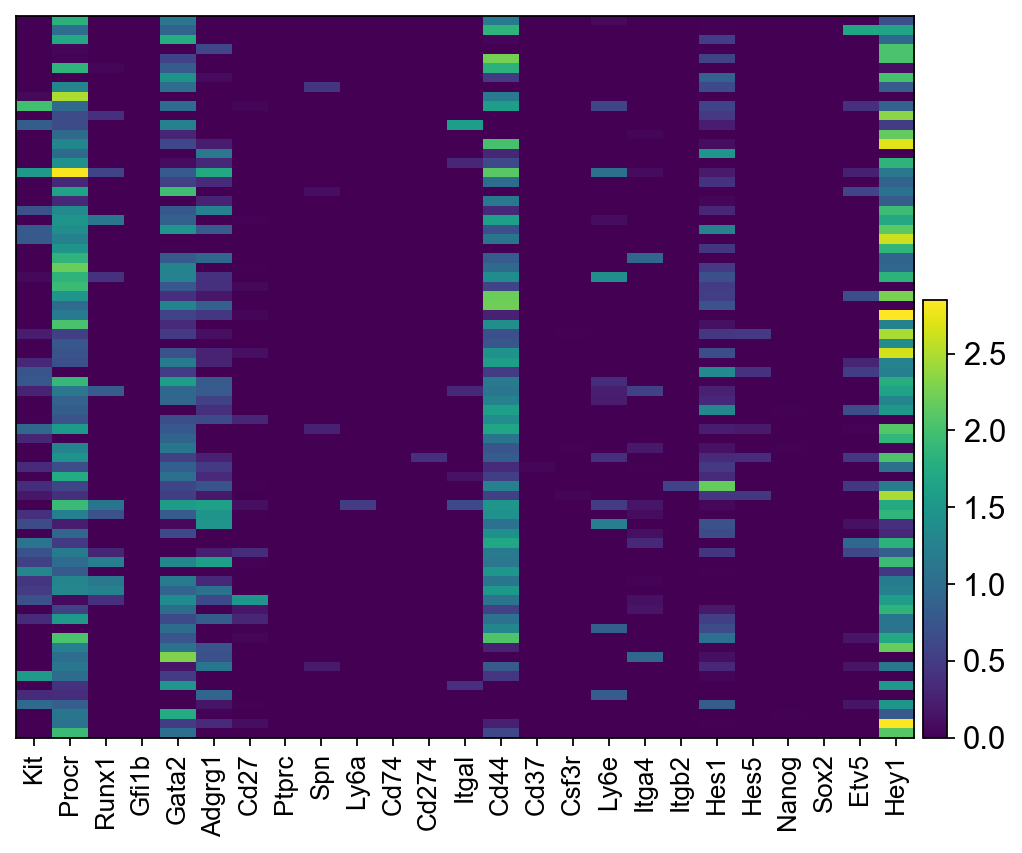

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0, 7.5, 0, 0.2])

In [121]:
# Heatmap with selected genes
sc.pl.heatmap(k3,['Kit','Procr','Runx1','Gfi1b','Gata2','Adgrg1','Cd27','Ptprc',
                     'Spn','Ly6a','Cd74','Cd274','Itgal','Cd44','Cd37',
                    'Csf3r','Ly6e','Itga4','Itgb2','Hes1','Hes5','Nanog','Sox2','Etv5','Hey1'],
              groupby='louvain',
              dendrogram=True,
              swap_axes=False)

In [ ]:
# Heatmap with Zhou genes EC vs T1 pre HSC
sc.pl.heatmap(adata,['Coro1a','Cd44','Itga4','Pdzk1ip1','Clu','Hlf','Plcg2',
                    'Runx1','Dok2','Fmnl1','Myb','Ptpn6','Ptk2b','Lyz2','Nfe2','Rab38',
                    'Stxbp2','Srgn','Fermt2','Ncf2'],
              groupby='Population',
              dendrogram=True,
              swap_axes=False)

In [ ]:
# Heatmap with Zhou genes T1 pre HSC vs. T2 pre HSCs
sc.pl.heatmap(adata,['Apip','Clpp','Coa3','Cerkl','Mctp1','Anapc11','Coprs',
                    'Mrpl20','Smim11','F5','Grap'],
              groupby='louvain',
              dendrogram=True,
              swap_axes=False)

In [ ]:
# Heatmap with Zhou genes T1 pre HSC vs. T2 pre HSCs
sc.pl.heatmap(adata,['Tspan18','Mmp2','Itgb3'],
              groupby='louvain',
              dendrogram=True,
              swap_axes=False)

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata,
                                n_genes=30,
                                show_gene_labels=True,
                               swap_axes=True)

### Comparing in the clusters the correlation Ab protein marker (upper case) - gene (lower case) 

In [ ]:
# T1 genes
sc.pl.umap(adata, color=['Cd55','Vwf','Car2','Chad','Acta2','Cd84','Coprs','Cd27','Mpl','Ptprc'], wspace=0.7,color_map=cmap,vmin=0)
sc.pl.umap(adata, color=['Cd48','Cd33','Cd52','Cd53','Cd68','Cd84','Cd180','Cd14','Cd83'], wspace=0.7,color_map=cmap,vmin=0)

In [ ]:
sc.pl.umap(adata, color=['Kit','Gfi1','Itga2b','Pecam1','Ptprc'], wspace=0.7,color_map=cmap,vmin=0)
sc.pl.umap(adata, color=['Notch1','Dll4','Notch2','Jag1'], wspace=0.7,color_map=cmap,vmin=0)

##### Ratio parameters can be created. Here, the ratio of ligands and receptors

In [ ]:
#Fringe proteins modulate Notch-mediated biological processes in a specific manner (Bigas and Espinosa, Blood 2012),
# such Lunatic Fringe (Lfng) in the hematopoetic lineage commitment and differentiation
sc.pl.umap(adata, color=['Lfng','Mfng','Rfng'], wspace=0.7,color_map=cmap,vmin=0)

# Lfng is highly expressed in one cell from cluster 4, corresponding to GFI+ IAHC population


In [ ]:
sc.pl.umap(adata, color=['Smad7','Smad6','Adam12'], wspace=0.7,color_map=cmap,vmin=0)

In [ ]:
sc.pl.umap(adata, color=['Notch1','Notch2','Notch3'], wspace=0.7,color_map=cmap,vmin=0)
sc.pl.umap(adata, color=['Notch4','Jag1','Jag2'], wspace=0.7,color_map=cmap,vmin=0)
sc.pl.umap(adata, color=['Dll1','Dll3','Dll4'], wspace=0.7,color_map=cmap,vmin=0)

In [ ]:
# HSC Gene markers
sc.pl.umap(adatared, color=['Gata2','Adgrg1','Cd27','Ptprc','Gpr171','Runx1','Gfi1b','Procr'],color_map=cmap,vmin=0)

In [ ]:
#Erythroids gene markers
sc.pl.umap(adatared, color=['Gata1','Epor','Hba-a1','Spi1'],color_map=cmap,vmin=0)

In [ ]:
#Neutrophils
sc.pl.umap(adatared, color=['Elane','Ctsg','Mpo'],color_map=cmap,vmin=0)

In [ ]:
#Bcells and lymphoids
sc.pl.umap(adatared, color=['Cd19','Cmtm7','Malt1','Plcl2'],color_map=cmap,vmin=0)
sc.pl.umap(adatared, color=['Slamf8','Cd79a','Il7r','Ikzf1'],color_map=cmap,vmin=0)

In [ ]:
sc.pl.umap(adatared, color=['Tcf7','Lef1','Stat6'],color_map=cmap,vmin=0)

In [ ]:
# lymphoid progenitor cell differentiation (GO BP)
sc.pl.umap(adatared, color=['Batf','Bmp4','Flcn','Flt3','Gata3','Spi1'],color_map=cmap,vmin=0)


In [ ]:
# Haemogenic endothelium
sc.pl.umap(adatared, color=['Efnb2','Ephb4','Foxc2','Sox17','Kdr','Cd34','Itga4'],color_map=cmap,vmin=0)

In [ ]:
sc.pl.umap(adatared, color=['Efnb2','Kdr','Cd34','Smad6','Smad7'],color_map=cmap,vmin=0)

In [ ]:
# VE-Cadherin gene, marker for endothelial cells
sc.pl.umap(adatared, color=['Cdh5','Pecam1','CD31','Gata2','Runx1','Sox7'],color_map=cmap,vmin=0)
sc.pl.umap(adatared, color=['orig'],color_map=cmap,vmin=0)

## Embedding the neighborhood graph -- PAGA

In [ ]:
#Compute neighbors, previously they were 5 in adatared
sc.pp.neighbors(rawadata, n_neighbors = 10)


In [ ]:
# Recommended use of UMAP (McInnes et al. 2018). More faithful to the global connectivity of the manifold than tSNE, 
# i.e., it better preserves trajectories. In some occasions, you might still observe disconnected clusters and 
# similar connectivity violations. They can usually be remedied by running:

sc.tl.draw_graph(rawadata)
#sc.pl.paga(adata)

In [ ]:
sc.pl.draw_graph(rawadata,color=['population','JAG1','orig'])

In [ ]:
# DENOISING GRAPH (not in PCA space) correcting with diffmap
sc.tl.diffmap(rawadata)
sc.pp.neighbors(rawadata, n_neighbors=10, use_rep='X_diffmap')

In [ ]:
sc.tl.draw_graph(rawadata)

In [ ]:
sc.pl.draw_graph(rawadata, color=['population','orig','louvain'])

In [ ]:
sc.tl.paga(rawadata, groups='louvain')

In [ ]:
sc.pl.paga(rawadata,color=['GFI1','orig'])

In [ ]:
sc.tl.draw_graph(rawadata,init_pos='paga')

In [ ]:
sc.pl.draw_graph(rawadata,color=['population','orig'])

In [ ]:
sc.pl.paga_compare(rawadata)

In [ ]:
#Estimating diffusion pseudotime, choose orig point! 
# orig or orig45!!!!
rawadata.uns['iroot'] = np.flatnonzero(rawadata.obs['orig'] == 'orig45')[0]
sc.tl.dpt(rawadata,n_dcs=15)

In [ ]:
sc.pl.umap(rawadata, color=['dpt_pseudotime',], color_map=cmap,wspace=0.5)
sc.pl.umap(rawadata, color=['JAG1','NOTCH1','DLL4',],color_map=cmap, wspace=0.5)
sc.pl.umap(rawadata, color=['Jag1','Notch1','Dll4'], color_map=cmap,wspace=0.5)
sc.pl.umap(rawadata, color=['Jag2','Notch3','Gata2'],color_map=cmap, wspace=0.5)


In [ ]:
sc.pl.draw_graph(rawadata,color=['dpt_pseudotime','Notch1','Jag1','Pecam1'],legend_loc='on data')
sc.pl.draw_graph(rawadata,color=['louvain','population','orig'])

In [ ]:
pst45=adatared.obs['dpt_pseudotime']
print(pst45)
export_csv = pst45.to_csv ('/Users/yguillen/Desktop/temp/scRNA_cam/scanpy_run/pseudotime_orig45.csv',header=True,index = True)

In [ ]:
pst=adatared.obs['dpt_pseudotime']
print(pst)
export_csv = pst.to_csv ('/Users/yguillen/Desktop/temp/scRNA_cam/scanpy_run/pseudotime.csv',header=True,index = True)

In [ ]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

In [ ]:
sc.pl.umap(adatared, color=['louvain'], legend_loc='on data')
sc.pl.umap(adatared, color=['dpt_pseudotime'],color_map=cmap)

### Finding differentially expressed marker genes among clusters

In [ ]:

# Let us compute a ranking for the highly differential genes in each cluster. 
#For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. 
# The simplest and fastest method to do so is the t-test.
#sc.tl.rank_genes_groups(adata, 'test_res1', method='t-test')
sc.tl.rank_genes_groups(adatared, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adatared, n_genes=40, sharey=False)


ranking genes
    finished (0:00:00)


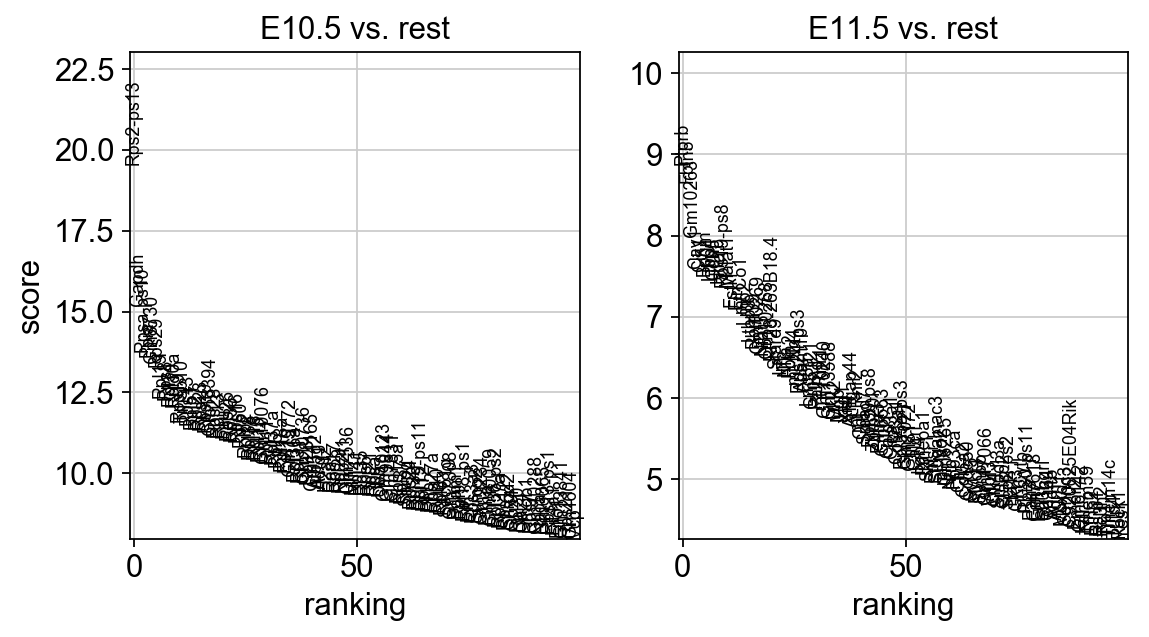

In [126]:
sc.tl.rank_genes_groups(k3, 'Time', method='t-test')
sc.pl.rank_genes_groups(k3, n_genes=100, sharey=False)

In [ ]:
# The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. 
# We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). 
# You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, 
# for python, the recent diffxpy.

sc.tl.rank_genes_groups(adatared, 'louvain','wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adatared, n_genes=30,sharey=True)

In [ ]:
# Saving the results
adata.write(results_file)

In [127]:
# Create a dataframe with DEGs comparison among clusters
k3.uns['rank_genes_groups']

{'params': {'groupby': 'Time',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': True,
  'corr_method': 'benjamini-hochberg'},
 'scores': rec.array([(19.548605 , 8.877325 ), (15.16447  , 8.650139 ),
            (13.755279 , 7.991082 ), (13.585699 , 7.59387  ),
            (13.42766  , 7.5503674), (13.302077 , 7.5031633),
            (12.331095 , 7.458111 ), (12.271913 , 7.4510193),
            (12.089777 , 7.41793  ), (12.055658 , 7.3708243),
            (11.59101  , 7.3686748), (11.548935 , 7.128606 ),
            (11.491084 , 7.0974665), (11.371683 , 7.047388 ),
            (11.370951 , 6.908236 ), (11.356343 , 6.702652 ),
            (11.29006  , 6.6143465), (11.181303 , 6.5569115),
            (11.1374855, 6.5327888), (11.113685 , 6.491581 ),
            (11.112305 , 6.467743 ), (11.05074  , 6.3562555),
            (10.998169 , 6.2983937), (10.988672 , 6.2686505),
            (10.814877 , 6.255173 ), (10.512379 , 6.168747 ),
            (10.457296 , 6.0779533), (10.43726  ,

In [128]:
degs = k3.uns['rank_genes_groups']
groups = degs['names'].dtype.names
dfdegs = pd.DataFrame({group + '_' + key[:1]: degs[key][group]
             for group in groups for key in ['names','logfoldchanges','pvals_adj']})
print(dfdegs)

      E10.5_n   E10.5_l       E10.5_p  E11.5_n    E11.5_l       E11.5_p
0   Rps2-ps13  6.857707  9.110508e-16    Ptprb   1.684924  2.925883e-10
1       Gapdh  3.051924  2.306751e-18    Fbln5  32.849075  1.038114e-08
2   Rpsa-ps10  4.222908  4.755750e-13  Gm10263   2.669806  6.366222e-09
3        Ppia  2.312243  1.890466e-17     Cav1   2.601141  3.963200e-08
4      Gm8730  2.277799  2.524944e-17     Clk1   1.455125  2.664505e-08
..        ...       ...           ...      ...        ...           ...
95       Eno1  1.942223  5.478485e-09     Tjp1   0.946229  2.869879e-03
96    Gm13841  2.416536  1.021698e-07  Tmem14c   2.500546  2.987937e-03
97      Rps21  1.009281  3.919921e-09    Tulp4   1.377264  3.138894e-03
98     Gm4604  1.988947  5.062218e-08    Rock1   1.444696  2.987937e-03
99        Vcp  1.409779  4.773408e-09     Yes1   1.943297  3.748046e-03

[100 rows x 6 columns]


In [129]:
#Print dataframe to csv file
export_csv = dfdegs.to_csv ('/Users/yolanda_guillen/Desktop/IMIM/scRNA_cam/all_scRNA_2021/output_DEGs_k3_HE_timepoint_wilcox_pval_adj.csv',header=True,index = False) #Don't forget to add '.csv' at the end of the path

In [ ]:
# To save raw data counts, and then export it
import anndata
adatared_copy = anndata.AnnData(X=adatared.raw.X, 
                                obs=adatared.obs, 
                                obsm=adatared.obsm,
                                uns=adatared.uns,
                                var=adatared.raw.var)

In [ ]:
# Export results (raw data counts). If scaled values, use adata instead of adata_copy
sc.external.exporting.cellbrowser(adatared_copy,data_dir='/Volumes/grcmc/YGUILLEN/scRNA_cam/scanpy_run/cellbrowser_noclust6_output/',data_name='adatared_sc_v2')

### DEGs between cluster 4 vs. others

In [ ]:

sc.pl.rank_genes_groups_violin(adatared, groups='4', n_genes=20)


In [ ]:
sc.pl.violin(adatared, ['Notch2', 'Kit', 'Gfi1b','Efnb2','Ephb4'], groupby='louvain')
sc.pl.violin(adatared, ['Adgrg1','Procr','Gata2','Cd27'], groupby='louvain')

#### Proportion of cells expressing markers genes in each cluster

In [ ]:
marker_genes = ['Notch2','Notch1','Dll4','Kit', 'Gfi1b','Adgrg1','Procr','Gata2','Cd27']
ax = sc.pl.dotplot(adatared, marker_genes,groupby='louvain')